# Problem Statement 

### Context 
When deciding what courses to take, the typical Harvard student looks first to the Q-Guide, a compilation of the wisdom of Harvard students not too yonder. It contains both descriptive facts about classes — such as class enrollment size, favorability rating of professors, and average weekly workload — as well as normative judgments by students in the form of open-response comments on the course. 

### Course of Action 
Through exploratory data analysis and model generation, we aim understand how these comments and ratings affect students' decisions to enroll in classes.

We also plan to investigate other questions of interest such as: How do departments differ in terms of average course sentiment? Do smaller concentrations lessen undesirable factors to boost enrollment? How do comments and grading styles differ between required vs elective courses?

### Goal 
 Our goal is to predict course enrollment in a course in the next year based on the three previous years Q-guide ratings. While doing so we will look at feature importance to identify the most significant predictors for a student to enroll in the course. 


# Step 0: Importing Libraries 

In [1]:
# Import libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from utils import course_department_map, spec_course_department_map


# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

# Step 1: Data Reading

In [2]:
# Load the datasets
df = pd.read_csv("data/data.csv", index_col = 0)
df.head()

C:\Users\AndrewsMatthewHaines\AppData\Local\Temp\ipykernel_28172\2013055878.py:2: DtypeWarning: Columns (56,58) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/data.csv", index_col = 0)


,web-scraper-order,web-scraper-start-url,course,comments,year,term,course_title,course_number1,department1,course_number2,department2,name_key1,instructor_first_name,instructor_last_name,enrollment,responses,number_of_comments,Course_Overall_Rating,Course_Materials_Rating,Course_Assignments_Rating,Course_Feedback_Rating,Course_Section_Rating,Course_Workload_Rating,Course_Goals_Rating,Course_Recommend_Rating,...,Course_Recommend_Respondents,Course_Money_Respondents,Instructor_Return_Respondents,Instructor_Feedback_Respondents,Instructor_Participation_Respondents,Instructor_Enthusiasm_Respondents,Instructor_Accessible_Respondents,Instructor_Lectures_Respondents,Instructor_Overall_Respondents,Course_Overall_Distribution,Course_Materials_Distribution,Course_Assignments_Distribution,Course_Feedback_Distribution,Course_Section_Distribution,Course_Workload_Distribution,Course_Goals_Distribution,Course_Recommend_Distribution,Course_Money_Distribution,Instructor_Return_Distribution,Instructor_Feedback_Distribution,Instructor_Participation_Distribution,Instructor_Enthusiasm_Distribution,Instructor_Accessible_Distribution,Instructor_Lectures_Distribution,Instructor_Overall_Distribution
0,1522891683-18234,https://course-evaluation-reports.fas.harvard.edu/fas/list?yearterm=2006_1,AFRAMER 112: Black Humor: Performance Art and Literature,[],2006,fall,Black Humor: Performance Art and Literature,112,AFRAMER,NaN,NaN,AFRAMER 112,"""","""",45,21,0,4.1,4.4,3.8,3.6,4.0,3.0,NaN,4.2,...,21.0,NaN,7.0,9.0,19.0,20.0,20.0,20.0,20.0,"[1, 3, 0, 6, 11]","[0, 1, 2, 5, 13]","[1, 3, 1, 9, 6]","[2, 4, 2, 5, 8]","[1, 1, 3, 8, 7]","[9, 11, 1, 0, 0]",NaN,"[3, 1, 0, 2, 15]",NaN,"[0, 1, 2, 2, 15]","[0, 1, 2, 7, 10]","[0, 0, 1, 3, 16]","[0, 0, 3, 1, 16]","[0, 0, 2, 3, 14]","[1, 0, 1, 4, 3]","[0, 0, 1, 3, 3]"
1,1522891674-18223,https://course-evaluation-reports.fas.harvard.edu/fas/list?yearterm=2006_1,"AFRAMER 113: Fictions of Race, Facts of Racism: Perspectives from South African and African Ame...",[],2006,fall,"Fictions of Race, Facts of Racism: Perspectives from South African and African American Drama an...",113,AFRAMER,NaN,NaN,AFRAMER 113,NaN,NaN,0,[],0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1522891670-18217,https://course-evaluation-reports.fas.harvard.edu/fas/list?yearterm=2006_1,AFRAMER 116: Autobiography and Literary Imagination,[],2006,fall,Autobiography and Literary Imagination,116,AFRAMER,NaN,NaN,AFRAMER 116,"""","""",9,5,0,4.5,4.2,3.8,3.2,3.8,10.0,NaN,4.8,...,4.0,NaN,3.0,3.0,4.0,4.0,4.0,4.0,4.0,"[0, 0, 0, 2, 2]","[0, 0, 0, 3, 1]","[0, 1, 1, 0, 2]","[1, 1, 0, 0, 2]","[1, 0, 0, 1, 2]","[0, 0, 2, 2, 0]",NaN,"[0, 0, 0, 1, 3]",NaN,"[0, 0, 0, 2, 2]","[0, 1, 0, 1, 2]","[0, 0, 1, 2, 1]","[0, 0, 0, 1, 3]","[0, 1, 0, 0, 3]","[0, 1, 0, 0, 2]","[0, 1, 0, 0, 2]"
3,1522891657-18200,https://course-evaluation-reports.fas.harvard.edu/fas/list?yearterm=2006_1,AFRAMER 175: Introduction to African Music,[],2006,fall,Introduction to African Music,175,AFRAMER,NaN,NaN,AFRAMER 175,"""","""",14,13,0,4.4,4.1,3.7,4.0,4.0,5.0,NaN,4.7,...,13.0,NaN,10.0,12.0,10.0,13.0,9.0,12.0,13.0,"[0, 1, 2, 1, 9]","[0, 1, 1, 7, 4]","[0, 1, 4, 6, 2]","[0, 1, 3, 4, 5]","[0, 0, 0, 1, 0]","[2, 7, 4, 0, 0]",NaN,"[0, 0, 0, 4, 9]",NaN,"[0, 0, 1, 3, 9]","[0, 0, 2, 3, 7]","[0, 1, 5, 1, 2]","[0, 0, 1, 4, 8]","[0, 1, 0, 3, 6]","[0, 2, 2, 6, 2]","[0, 1, 3, 4, 2]"
4,1522891495-18013,https://course-evaluation-reports.fas.harvard.edu/fas/list?yearterm=2006_1,"AFRAMER 190: African-American Families: Politics, Culture, Experience",[],2006,fall,"African-American Families: Politics, Culture, Experience",190,AFRAMER,NaN,NaN,AFRAMER 190,"""","""",13,8,0,4.4,4.4,4.1,4.1,0.0,3.0,NaN,4.4,...,7.0,NaN,6.0,6.0,7.0,7.0,6.0,7.0,7.0,"[0, 0, 1, 2, 4]","[0, 0, 0, 4, 3]","[0, 1, 0, 3, 3]","[0, 1, 0, 3, 3]",[],"[2, 5, 0, 0, 0]",NaN,"[0, 0, 1, 2, 4]",NaN,"[0, 0, 1, 2, 4]","[0, 0, 1, 4, 2]","[0, 1, 1, 0, 4]","[0, 0, 1, 3, 3]","[0, 0, 1,

# Step 2 Creating New Course Categories 
The following code is used to create both general and specific course categories to make more meaningful insights into the data. 

For general categories, courses are divided into 'Arts & Humanities', 'STEM', 'Social Sciences', 'Expository', 'General Education', and 'First-Year' departments. For specific categories, these general ones are broken down further into more specific sub-types. 

### Create general and specific class categories and do some cleaning

In [3]:
df_copy = df.copy()

# Make responses numeric, and calculate response rate
df_copy["responses"] = pd.to_numeric(df_copy["responses"], errors='coerce', downcast='integer')
df_copy['response_rate'] = df_copy['responses'] / df_copy['enrollment']

# Ensure the year is consistent change from academic year to calendar year
df_copy['school_year'] = df_copy.apply(lambda row: str(row['year']) if row['term'] == 'Spring' else str(row['year'] - 1), axis=1)

# Add division and spec_division columns from utils.py
df_copy['division'] = np.vectorize(course_department_map.get)(df_copy['department1'])
df_copy['spec_division'] = np.vectorize(spec_course_department_map.get)(df_copy['department1'])

# View the changed/new columns
df_copy[["responses","school_year", "response_rate","division", "spec_division"]].head()

,responses,school_year,response_rate,division,spec_division
0,21.0,2005,0.467,social_science,ethnic_studies
1,NaN,2005,NaN,social_science,ethnic_studies
2,5.0,2005,0.556,social_science,ethnic_studies
3,13.0,2005,0.929,social_science,ethnic_studies
4,8.0,2005,0.615,social_science,ethnic_studies


### Lecture or Seminar

We decided that we define a lecture as > 20 people because from our experience 20 people is the maximum number of people you can have in a seminar with faciliated discussion and when we plot it below it seems at though 20 people is a natural dropoff point.

<Axes: xlabel='enrollment', ylabel='Count'>

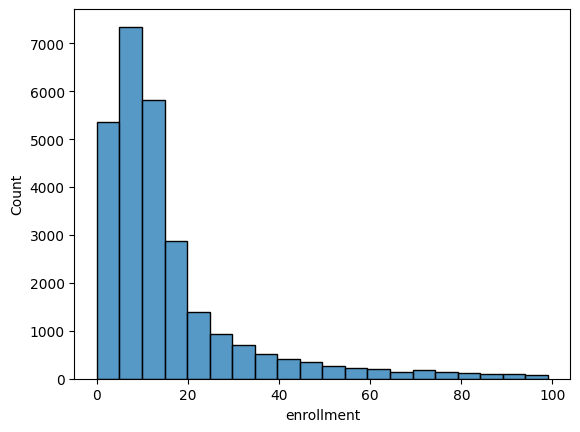

In [4]:
sns.histplot(data=df_copy[df_copy["enrollment"] < 100], x="enrollment", bins=20)

In [5]:
threshold = 20  
df_copy['course_type'] = df_copy['enrollment'].apply(lambda x: 'seminar' if x <= threshold else 'lecture')

# Step 3: Identifiying and Cleaning Missing Data 
Look at the missing data and drop columns with more than 50% of the data missing. Includes summary statistics, and data shapes.

### Generating Missingness Percentage for Each Column

In [6]:
# Calculate the percentage of missing values for each column
missing_percentage = df_copy.isnull().mean() * 100

# Display the percentage of missing data by column
missing_percentage.sort_values(ascending=False)

Course_Goals_Respondents                 99.996
Course_Goals_Distribution                99.996
Course_Goals_Rating                      99.996
course_number2                           99.060
department2                              99.060
Course_Money_Distribution                91.721
Course_Money_Rating                      91.718
Course_Money_Respondents                 91.718
Instructor_Return_Distribution           34.960
Instructor_Return_Respondents            34.960
Instructor_Return_Rating                 34.960
Instructor_Enthusiasm_Respondents        33.097
Instructor_Enthusiasm_Distribution       33.097
Instructor_Enthusiasm_Rating             33.097
Instructor_Overall_Distribution          29.632
Instructor_Overall_Rating                29.632
Instructor_Overall_Respondents           29.632
Instructor_Participation_Respondents     29.622
Instructor_Lectures_Rating               29.622
Instructor_Accessible_Rating             29.622
Instructor_Accessible_Respondents       

### Removing Columns with more than 50% Missingness

Note we impute values below after our EDA

In [7]:
# Remove columns with more than 50% missing values
columns_to_drop = missing_percentage[missing_percentage > 50].index
data_cleaned = df_copy.drop(columns=columns_to_drop)
data_cleaned = data_cleaned.drop(columns = ['web-scraper-order','web-scraper-start-url'])

# Show the shape of the data before and after
original_shape = df.shape
cleaned_shape = data_cleaned.shape

original_shape, cleaned_shape, columns_to_drop.tolist()

((28398, 65),
 (28398, 60),
 ['course_number2',
  'department2',
  'Course_Goals_Rating',
  'Course_Money_Rating',
  'Course_Goals_Respondents',
  'Course_Money_Respondents',
  'Course_Goals_Distribution',
  'Course_Money_Distribution'])

In [8]:
data_cleaned.describe()

,year,enrollment,responses,number_of_comments,Course_Overall_Rating,Course_Materials_Rating,Course_Assignments_Rating,Course_Feedback_Rating,Course_Section_Rating,Course_Workload_Rating,Course_Recommend_Rating,Instructor_Return_Rating,Instructor_Feedback_Rating,Instructor_Participation_Rating,Instructor_Enthusiasm_Rating,Instructor_Accessible_Rating,Instructor_Lectures_Rating,Instructor_Overall_Rating,Course_Overall_Respondents,Course_Materials_Respondents,Course_Assignments_Respondents,Course_Feedback_Respondents,Course_Section_Respondents,Course_Workload_Respondents,Course_Recommend_Respondents,Instructor_Return_Respondents,Instructor_Feedback_Respondents,Instructor_Participation_Respondents,Instructor_Enthusiasm_Respondents,Instructor_Accessible_Respondents,Instructor_Lectures_Respondents,Instructor_Overall_Respondents,response_rate
count,28398.000,28398.000,25209.000,28398.000,25001.000,25001.000,25001.000,25001.000,25000.000,24896.000,25001.000,18470.000,19991.000,19986.000,18999.000,19986.000,19986.000,19983.000,25001.000,25001.000,25001.000,25001.000,25000.000,25001.000,25001.000,18470.000,19991.000,19986.000,18999.000,19986.000,19986.000,19983.000,25209.000
mean,2012.243,22.517,20.311,11.861,4.225,4.175,4.077,4.081,3.618,5.977,4.262,4.324,4.011,4.218,4.409,4.259,4.222,4.373,20.088,19.458,19.605,19.227,15.043,19.254,19.967,8.152,7.741,12.607,18.500,15.952,18.113,18.737,0.784
std,3.416,48.031,42.742,46.760,0.579,0.748,0.754,0.805,1.678,3.873,0.576,0.699,1.171,0.931,0.740,0.802,0.936,0.563,42.292,41.786,42.120,41.471,39.593,41.186,42.107,10.331,9.545,19.857,36.224,29.532,36.252,36.375,0.196
min,2006.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.028
25%,2009.000,6.000,5.000,0.000,3.900,3.900,3.800,3.700,3.400,4.000,4.000,4.000,3.800,4.000,4.200,4.000,4.000,4.000,5.000,5.000,5.000,5.000,1.000,5.000,5.000,3.000,3.000,4.000,5.000,5.000,4.000,5.000,0.667
50%,2012.000,11.000,9.000,0.000,4.300,4.300,4.200,4.200,4.200,5.400,4.300,4.500,4.300,4.400,4.600,4.400,4.500,4.500,9.000,9.000,9.000,9.000,3.000,9.000,9.000,6.000,6.000,7.000,9.000,8.000,8.000,9.000,0.833
75%,2015.000,19.000,17.000,8.000,4.700,4.600,4.500,4.600,4.800,7.200,4.700,4.900,4.800,4.800,4.900,4.800,4.800,4.800,17.000,16.000,16.000,16.000,11.000,16.000,17.000,10.000,10.000,13.000,16.000,15.000,16.000,16.000,0.929
max,2018.000,921.000,856.000,2246.000,5.000,5.000,5.000,5.000,5.000,96.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,849.000,848.000,848.000,848.000,733.000,851.000,847.000,202.000,191.000,597.000,707.000,594.000,712.000,713.000,2.750


# Step 4: Exploratory Data Analysis
Analyzing data and generating visualizations by focusing on trends across general departments. By doing so, this will inform our model pipeline later on. 

In [9]:
average_enrollment = data_cleaned.groupby('division')['enrollment'].mean().reset_index()
average_enrollment

,division,enrollment
0,arts_humanities,15.048
1,expository,26.489
2,first_year,9.311
3,general_education,72.102
4,misc,5.333
5,social_science,24.021
6,stem,29.155


### Visualizing Average Enrollment 

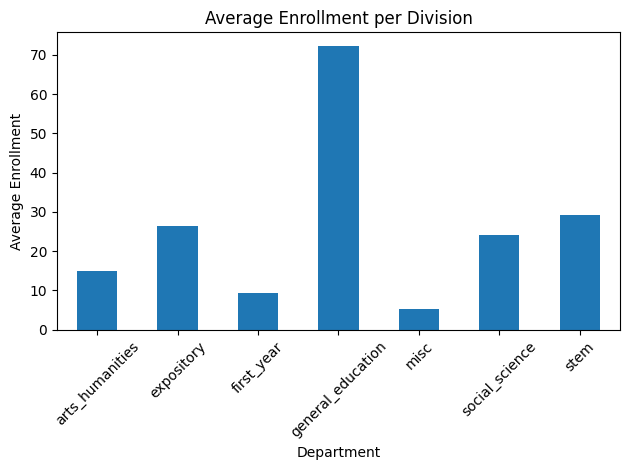

In [10]:
# Plot the average enrollment per department as a bar chart
average_enrollment.plot(kind='bar', x='division', y='enrollment', legend=False)

# Set the title and labels
plt.title('Average Enrollment per Division')
plt.xlabel('Department')
plt.ylabel('Average Enrollment')
plt.xticks(rotation=45)  # Rotate the x-axis labels to show them better

# Show the plot
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()

### Visualizing Total Enrollment 

Text(0, 0.5, 'Total Enrollment')

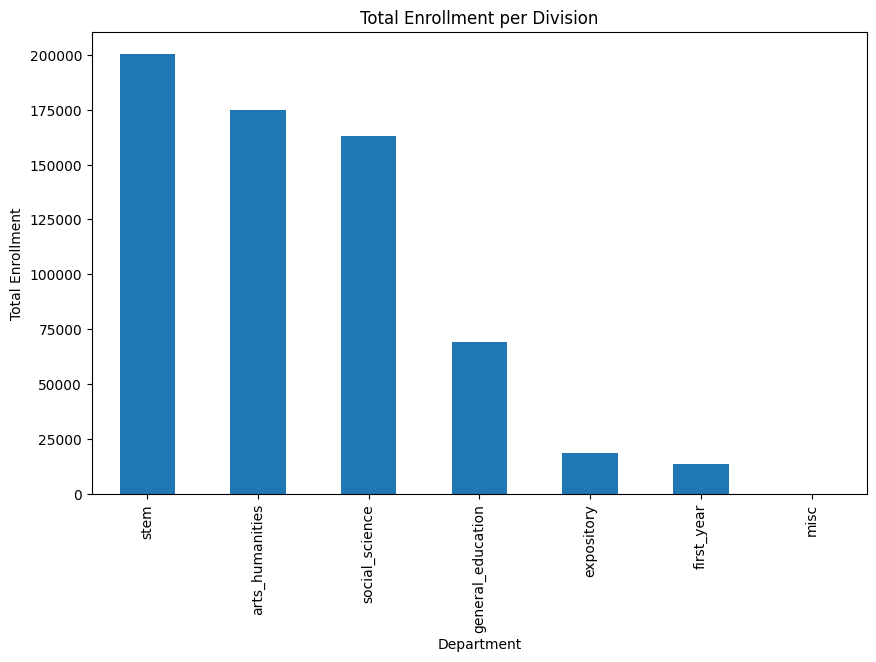

In [11]:
total_enrollment = data_cleaned.groupby('division')['enrollment'].sum().sort_values(ascending=False)

# Plotting the total enrollment per department as a bar chart
total_enrollment.plot(kind='bar', figsize=(10, 6))

# Adding title and labels
plt.title('Total Enrollment per Division')
plt.xlabel('Department')
plt.ylabel('Total Enrollment')

### Visualizing Total Enrollment over Time

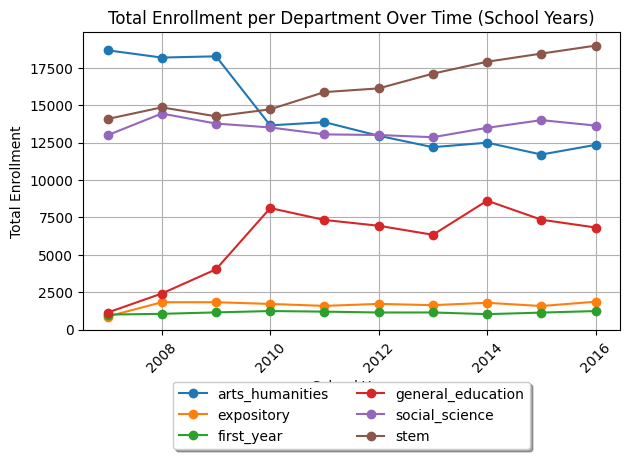

In [12]:
# Filter out 'misc' department and the years 2005 and 2017
filtered_df = data_cleaned[(data_cleaned['division'] != 'misc') & (data_cleaned['year'] > 2006) & (data_cleaned['year'] < 2017)]

# Group by department and school_year and sum enrollment
grouped_df_filtered = filtered_df.groupby(['division', 'year']).agg({'enrollment': 'sum'}).reset_index()

# Pivot the DataFrame for easier plotting
pivot_df_filtered = grouped_df_filtered.pivot(index='year', columns='division', values='enrollment')

# Plotting
pivot_df_filtered.plot(kind='line', marker='o')
plt.title('Total Enrollment per Department Over Time (School Years)')
plt.xlabel('School Year')
plt.ylabel('Total Enrollment')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
plt.tight_layout()
plt.show()

In [13]:
data_cleaned.loc[(data_cleaned['enrollment'] > 20) & 
            (data_cleaned['division'] == 'expository') & 
            (data_cleaned['year'].isin([2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020])), 'enrollment'] = 20

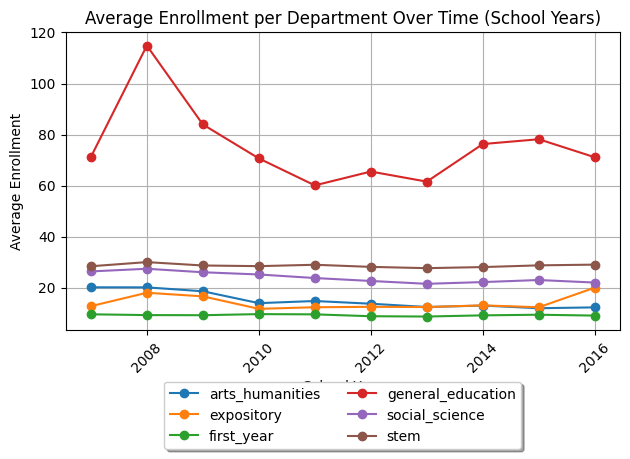

In [14]:
# Filter out 'misc' department and the years 2005 and 2017
filtered_df = data_cleaned[(data_cleaned['division'] != 'misc') & (data_cleaned['year'] > 2006) & (data_cleaned['year'] < 2017)]

# Group by department and school_year and sum enrollment
grouped_df_filtered = filtered_df.groupby(['division', 'year']).agg({'enrollment': 'mean'}).reset_index()

# Pivot the DataFrame for easier plotting
pivot_df_filtered = grouped_df_filtered.pivot(index='year', columns='division', values='enrollment')

# Plotting
pivot_df_filtered.plot(kind='line', marker='o')
plt.title('Average Enrollment per Department Over Time (School Years)')
plt.xlabel('School Year')
plt.ylabel('Average Enrollment')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
plt.tight_layout()
plt.show()

### Visualizing Average Response Rate 

In [15]:
# For the sake of visualization - drop all classes with enrollment below 5 (outliers)
# Note we do not drop this in our modelling
df_copy_drop5 = data_cleaned[(data_cleaned['enrollment'] > 5) & (data_cleaned['division'] != 'misc')]

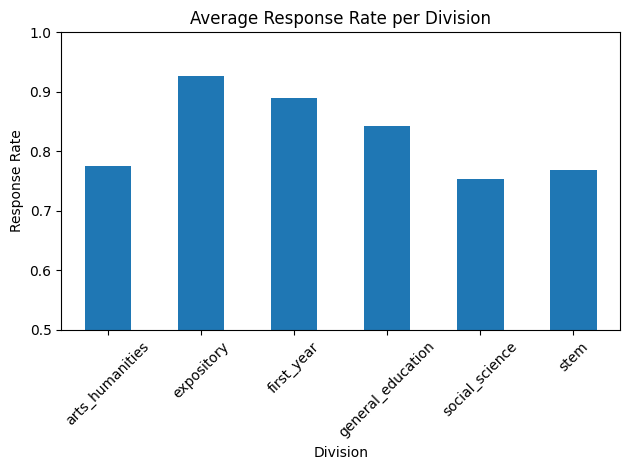

In [16]:
average_rr = df_copy_drop5.groupby('division')['response_rate'].mean().reset_index()

# Plot the average enrollment per department as a bar chart
average_rr.plot(kind='bar', x='division', y='response_rate', legend=False)

# Set the title and labels
plt.title('Average Response Rate per Division')
plt.xlabel('Division')
plt.ylabel('Response Rate')
plt.ylim(0.5, 1)
plt.xticks(rotation=45)  # Rotate the x-axis labels to show them better

# Show the plot
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()

### Visualizing Average Course Rating Variables 

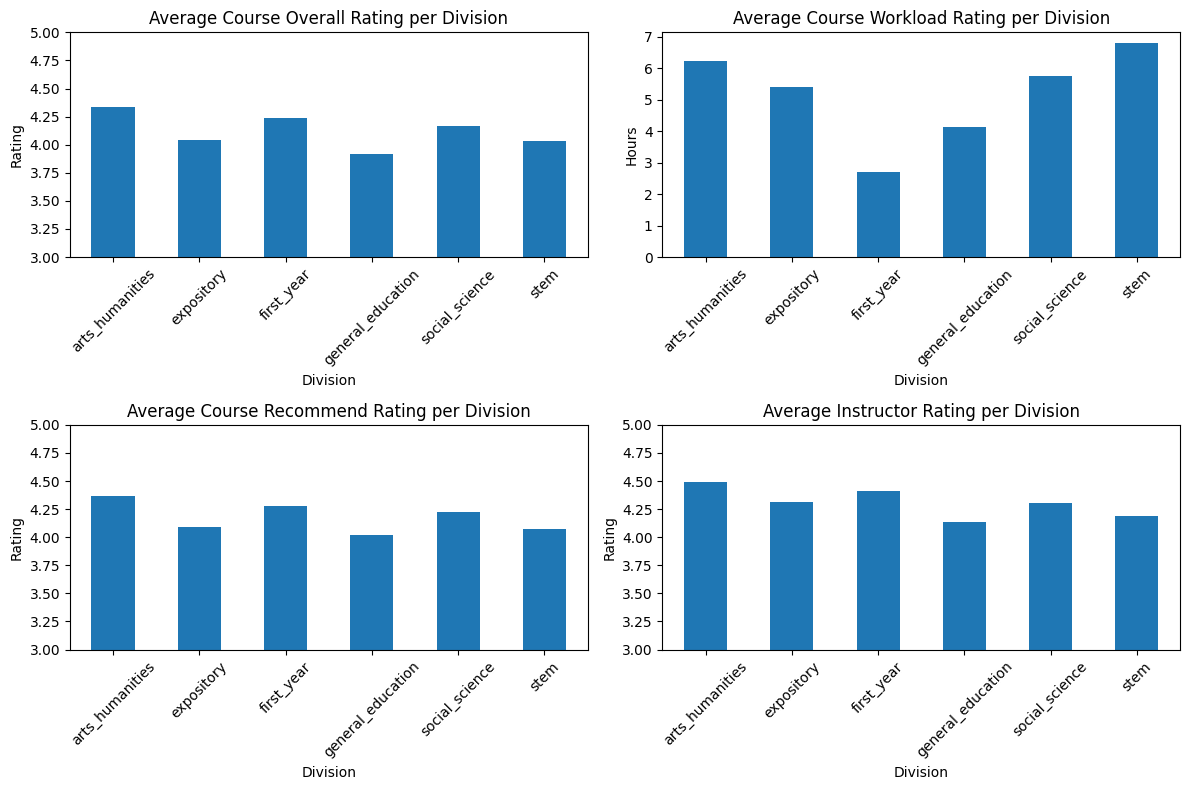

In [17]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# First plot
average_cor = df_copy_drop5.groupby('division')['Course_Overall_Rating'].mean().reset_index()
average_cor.plot(kind='bar', x='division', y='Course_Overall_Rating', legend=False, ax=axs[0, 0])
axs[0, 0].set_title('Average Course Overall Rating per Division')
axs[0, 0].set_xlabel('Division')
axs[0, 0].set_ylabel('Rating')
axs[0, 0].set_ylim(3, 5)
axs[0, 0].tick_params(axis='x', rotation=45)

# Second plot
average_cwr = df_copy_drop5.groupby('division')['Course_Workload_Rating'].mean().reset_index()
average_cwr.plot(kind='bar', x='division', y='Course_Workload_Rating', legend=False, ax=axs[0, 1])
axs[0, 1].set_title('Average Course Workload Rating per Division')
axs[0, 1].set_xlabel('Division')
axs[0, 1].set_ylabel('Hours')
axs[0, 1].tick_params(axis='x', rotation=45)

# Third plot
average_crr = df_copy_drop5.groupby('division')['Course_Recommend_Rating'].mean().reset_index()
average_crr.plot(kind='bar', x='division', y='Course_Recommend_Rating', legend=False, ax=axs[1, 0])
axs[1, 0].set_title('Average Course Recommend Rating per Division')
axs[1, 0].set_xlabel('Division')
axs[1, 0].set_ylabel('Rating')
axs[1, 0].set_ylim(3, 5)
axs[1, 0].tick_params(axis='x', rotation=45)

# Fourth plot
average_ior = df_copy_drop5.groupby('division')['Instructor_Overall_Rating'].mean().reset_index()
average_ior.plot(kind='bar', x='division', y='Instructor_Overall_Rating', legend=False, ax=axs[1, 1])
axs[1, 1].set_title('Average Instructor Rating per Division')
axs[1, 1].set_xlabel('Division')
axs[1, 1].set_ylabel('Rating')
axs[1, 1].set_ylim(3, 5)
axs[1, 1].tick_params(axis='x', rotation=45)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

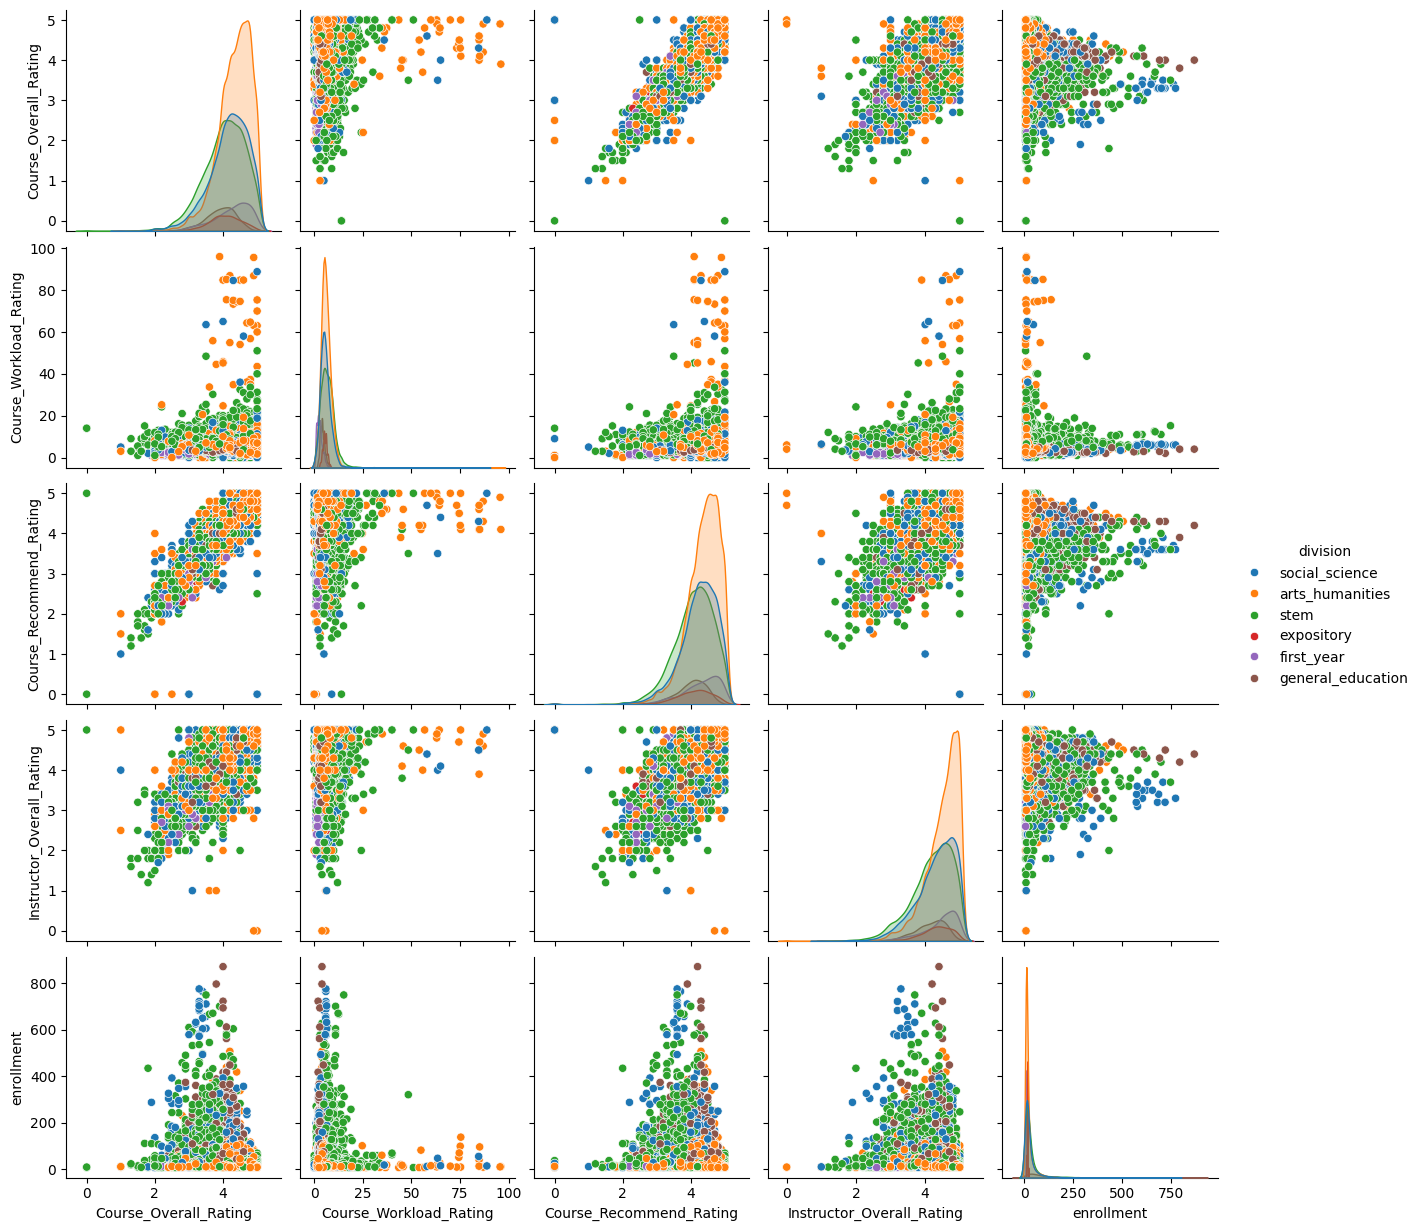

In [18]:
df_copy_drop5 = df_copy_drop5.reset_index(drop=True)

# Select only the columns you're interested in
columns = ['Course_Overall_Rating', 'Course_Workload_Rating', 'Course_Recommend_Rating', 'Instructor_Overall_Rating', 'enrollment', 'division']

# Create a pairplot using Seaborn
sns.pairplot(df_copy_drop5[columns], hue = "division")

# Show the plot
plt.show()

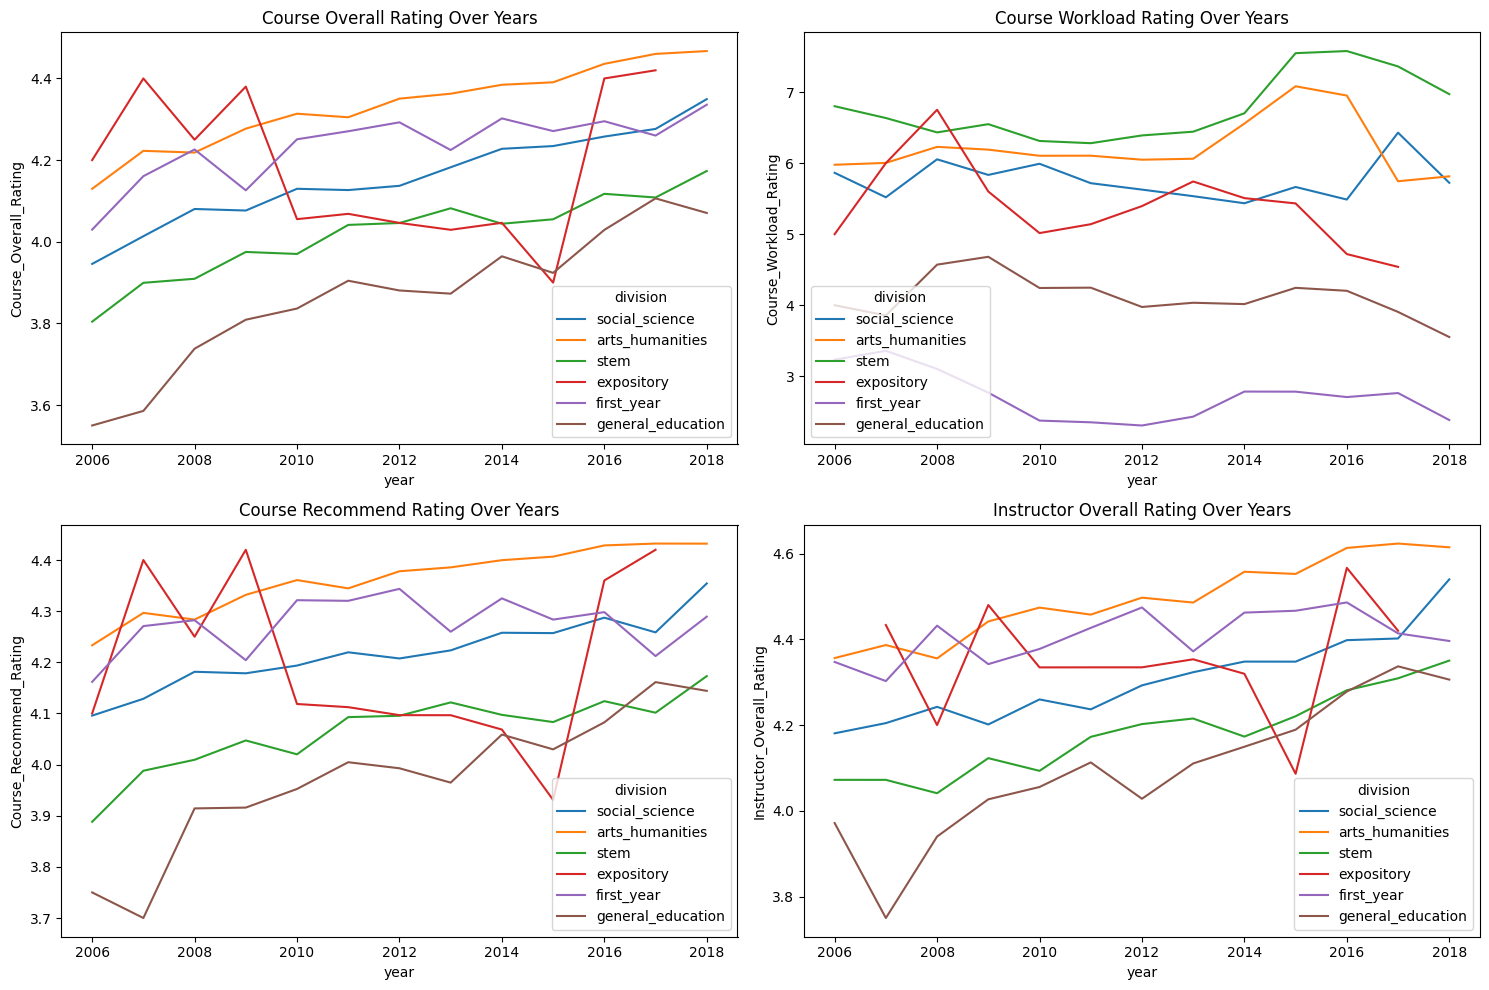

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Assuming the year column is named 'year'
# Replace 'df' with the name of your DataFrame

# Plot 1: Course_Overall_Rating over years
sns.lineplot(data=df_copy_drop5, x='year', y='Course_Overall_Rating', hue='division', ax=axs[0, 0], errorbar = None)
axs[0, 0].set_title('Course Overall Rating Over Years')

# Plot 2: Course_Workload_Rating over years
sns.lineplot(data=df_copy_drop5, x='year', y='Course_Workload_Rating', hue='division', ax=axs[0, 1], errorbar = None)
axs[0, 1].set_title('Course Workload Rating Over Years')

# Plot 3: Course_Recommend_Rating over years
sns.lineplot(data=df_copy_drop5, x='year', y='Course_Recommend_Rating', hue='division', ax=axs[1, 0], errorbar = None)
axs[1, 0].set_title('Course Recommend Rating Over Years')

# Plot 4: Instructor_Overall_Rating over years
sns.lineplot(data=df_copy_drop5, x='year', y='Instructor_Overall_Rating', hue='division', ax=axs[1, 1], errorbar = None)
axs[1, 1].set_title('Instructor Overall Rating Over Years')

# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()

# Step 5: Scale

In [20]:
# log enrollment numbers (to not have inf replace 0 with 1e-9)
data_cleaned['enrollment'] = data_cleaned['enrollment'].replace(0, 1e-9)
data_cleaned['log_enrollment'] = np.log(data_cleaned['enrollment'])

# normalize workload hours
std_scaler = StandardScaler()
data_cleaned['norm_Course_Workload_Rating'] = std_scaler.fit_transform(data_cleaned[['Course_Workload_Rating']])

In [21]:
# Remove infinite values
data_cleaned.replace([np.inf, -np.inf], np.nan, inplace=True)

# Step 6: Begin Imputing

In [22]:
# Identify the data types of the remaining columns
column_data_types = data_cleaned.dtypes

# Separate columns by data type for potential different imputation methods
categorical_columns = column_data_types[column_data_types == 'object'].index.tolist()
numerical_columns = column_data_types[column_data_types != 'object'].index.tolist()

In [23]:
# Impute missing values for numerical columns with median
num_imputer = SimpleImputer(strategy='median')  
data_cleaned[numerical_columns] = num_imputer.fit_transform(data_cleaned[numerical_columns])

# Impute missing values for categorical columns with mode
cat_imputer = SimpleImputer(strategy='most_frequent')
data_cleaned[categorical_columns] = cat_imputer.fit_transform(data_cleaned[categorical_columns])

# Step 7: Train-test split

Since we are using panel data and predicting enrollment in the next year using previous year's data, we split the data into multiple training sets which have associated validation sets, i.e. 2006-2008 is the first training set and we split 2009 into half validation and half test since this is the data we're predicting on. We then do the same thing again and again with our second training set being 2007-2009 with our validation/test set being 2010.

In [24]:
# Convert the 'year' column back to integers (after imputation it was converted to float)
data_cleaned['year'] = data_cleaned['year'].astype('int64')

# Initialize dictionaries to hold the training, validation, and test sets
training_sets = {}
validation_sets = {}
test_sets = {}

# Iterate over the years to create the sets
for start_year in range(2006, 2016):  # last training set starts in 2015
    end_year = start_year + 2  # end year of the training set
    val_year = end_year + 1  # validation year

    # Assign the traininging set
    training_sets[f"{start_year}-{end_year}"] = data_cleaned[data_cleaned['year'].between(start_year, end_year)]

    # Shuffle the dataset for validation and test sets
    data_shuffled = data_cleaned[(data_cleaned['year'] == val_year)].sample(frac=1, random_state=42).reset_index(drop=True)

    # Split the dataset into validation and test sets 
    # TODO: Check
    validation_sets[f"{val_year}"], test_sets[f"{val_year}"] = train_test_split(data_shuffled, test_size=0.5, stratify=data_shuffled['year'], random_state=42)

In [53]:

training_threshhold = 2
counter = 0
courses = data_cleaned.name_key1.unique()
for i,j in enumerate(courses):
    name = j
    if data_cleaned[data_cleaned.name_key1 == name].shape[0] > training_threshhold:
        counter += 1
    
print(counter/len(courses))

KeyboardInterrupt: 

In [25]:
X_trains = {}
y_trains = {}
X_valids = {}
y_valids = {}
X_tests = {}
y_tests = {}

for key, train_data in training_sets.items():
    X_trains[key] = train_data.drop('log_enrollment', axis=1)  # Features
    X_trains[key] = pd.get_dummies(X_trains[key], columns=['division'])
    y_trains[key] = train_data['log_enrollment']  # Target variable

for key, valid_data in validation_sets.items():
    X_valids[key] = valid_data.drop('log_enrollment', axis=1)  # Features
    X_valids[key] = pd.get_dummies(X_valids[key], columns=['division'])
    y_valids[key] = valid_data['log_enrollment']  # Target variable

for key, valid_data in test_sets.items():
    X_tests[key] = valid_data.drop('log_enrollment', axis=1)  # Features
    X_tests[key] = pd.get_dummies(X_tests[key], columns=['division'])
    y_tests[key] = valid_data['log_enrollment']  # Target variable

# Step 8: HT TODO Basic Linear Regression

In [26]:
lreg1_variables = ["Course_Overall_Rating","Course_Workload_Rating","Course_Recommend_Rating","Instructor_Overall_Rating", "division", "course_type", "enrollment"]

In [27]:
sample_train = training_sets['2012-2014'][lreg1_variables].copy()
sample_test = test_sets['2015'][lreg1_variables].copy()

sample_train.replace("NaN", np.nan, inplace=True)
sample_test.replace("NaN", np.nan, inplace=True)

sample_train.dropna(inplace=True)
sample_test.dropna(inplace=True)

print(sample_train.shape, sample_test.shape)
display(sample_train.head())
sample_train.info()

(7599, 7) (1258, 7)


,Course_Overall_Rating,Course_Workload_Rating,Course_Recommend_Rating,Instructor_Overall_Rating,division,course_type,enrollment
0,4.3,5.4,4.3,4.5,general_education,seminar,1.000e-09
1,4.3,5.4,4.3,4.5,general_education,seminar,1.000e-09
2,3.8,4.0,4.0,4.5,general_education,lecture,2.600e+01
3,4.7,5.0,4.8,4.8,general_education,lecture,2.400e+01
4,3.3,4.0,3.4,3.7,general_education,lecture,6.400e+01


<class 'pandas.core.frame.DataFrame'>
Index: 7599 entries, 0 to 1259
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Course_Overall_Rating      7599 non-null   float64
 1   Course_Workload_Rating     7599 non-null   float64
 2   Course_Recommend_Rating    7599 non-null   float64
 3   Instructor_Overall_Rating  7599 non-null   float64
 4   division                   7599 non-null   object 
 5   course_type                7599 non-null   object 
 6   enrollment                 7599 non-null   float64
dtypes: float64(5), object(2)
memory usage: 474.9+ KB


In [28]:
X_train, y_train = sample_train.drop(columns = ["enrollment"]), sample_train["enrollment"]
X_test, y_test = sample_test.drop(columns = ["enrollment"]), sample_train["enrollment"]

Little data wrangling for one hot encoding division category and making course type into dummy variable

In [29]:
encoder = OneHotEncoder()
encoded = encoder.fit_transform(X_train[['division']]).toarray()
feature_names = [f"division_{cat}" for cat in encoder.categories_[0]]
encoded_df = pd.DataFrame(encoded, columns=feature_names)

X_train_reset = X_train.reset_index()
X_train_combined = X_train_reset.join(encoded_df, how = 'inner')

In [30]:
encoded = encoder.fit_transform(X_test[['division']]).toarray()
feature_names = [f"division_{cat}" for cat in encoder.categories_[0]]
encoded_df = pd.DataFrame(encoded, columns=feature_names)

X_test_reset = X_test.reset_index(drop=True)
X_test_combined = X_test_reset.join(encoded_df, how = 'inner')

X_train_combined['c_type'] = X_train_combined['course_type'].map({'seminar': 1, 'lecture': 0})
X_test_combined['c_type'] = X_test_combined['course_type'].map({'seminar': 1, 'lecture': 0})

In [31]:
lreg1_predictors = ["Course_Overall_Rating","Course_Workload_Rating","Course_Recommend_Rating","Instructor_Overall_Rating", "division_arts_humanities", "division_first_year", "division_general_education", "division_social_science", "division_stem"]

In [32]:
lreg1_1 = LinearRegression().fit(X_train_combined[lreg1_predictors], y_train)

y_pred_train = lreg1_1.predict(X_test_combined[lreg1_predictors])
y_pred_test = lreg1_1.predict(X_test_combined[lreg1_predictors])

coefficients = lreg1_1.coef_


feature_names = X_train_combined[lreg1_predictors].columns

# Print each feature name with its corresponding coefficient
for feature, coef in zip(feature_names, coefficients):
    print(f"{feature}: {coef}")

Course_Overall_Rating: -16.067659052956685
Course_Workload_Rating: 0.07215574715605122
Course_Recommend_Rating: 3.6780182092853715
Instructor_Overall_Rating: -3.990597100880739
division_arts_humanities: 5.227552947625425
division_first_year: -0.3033631398485656
division_general_education: 53.54164887795533
division_social_science: 11.426464743640258
division_stem: 15.575021729180142


# Step 9: Create the models

We create 3 basic baseline models of Linear Regression, Decision Tree, Randome Forest before tuning these models and running them again so at the end (Step 13) we can discuss the different models by looking at their train, validation, and test MSEs.

In [33]:
total_results = []

In [34]:
# For best model single dataset
key = '2006-2008'
numerical_columns_2006 = X_trains[key].select_dtypes(include=['number'])

### Untuned Models

In [35]:
def evaluate_models(X_trains, y_trains, X_valids, y_valids, models):
    results = {}
    num_models = len(models)
    fig, ax = plt.subplots(num_models, 1, figsize=(10, 5 * num_models))
    if num_models == 1:
        ax = [ax]  # Ensure ax is iterable even for a single model

    for i, (model_name, model) in enumerate(models.items()):
        train_mses = []
        valid_mses = []
        
        # Ensure that we have the same order of keys for both training and validation sets
        train_keys = list(X_trains.keys())
        valid_keys = list(X_valids.keys())

        for j, key in enumerate(train_keys):
            corresponding_valid_key = valid_keys[j]

            # Training set preparation
            X_train, y_train = X_trains[key].copy(), y_trains[key].copy()
            X_train = X_train.select_dtypes(include=['number'])

            # Validation set preparation
            X_valid, y_valid = X_valids[corresponding_valid_key].copy(), y_valids[corresponding_valid_key].copy()
            X_valid = X_valid.select_dtypes(include=['number'])

            # Model training and prediction
            model.fit(X_train, y_train)
            y_train_pred = model.predict(X_train)
            y_valid_pred = model.predict(X_valid)

            # Compute metrics
            train_mse = mean_squared_error(y_train, y_train_pred)
            valid_mse = mean_squared_error(y_valid, y_valid_pred)
            train_mses.append(train_mse)
            valid_mses.append(valid_mse)

            # Additional metrics
            train_r2 = r2_score(y_train, y_train_pred)
            valid_r2 = r2_score(y_valid, y_valid_pred)
            train_mae = mean_absolute_error(y_train, y_train_pred)
            valid_mae = mean_absolute_error(y_valid, y_valid_pred)

            results.setdefault(model_name, []).append({
                'train_key': key,
                'valid_key': corresponding_valid_key,
                'train_mse': train_mse,
                'valid_mse': valid_mse,
                'train_r2': train_r2,
                'valid_r2': valid_r2,
                'train_mae': train_mae,
                'valid_mae': valid_mae
            })

        # Plotting
        ax[i].plot(train_keys, train_mses, label='Train MSE')
        ax[i].plot(train_keys, valid_mses, label='Valid MSE')
        ax[i].set_title(model_name)
        ax[i].set_xlabel('Dataset Index')
        ax[i].set_ylabel('MSE')
        ax[i].legend()

    plt.tight_layout()
    plt.show()

    return results

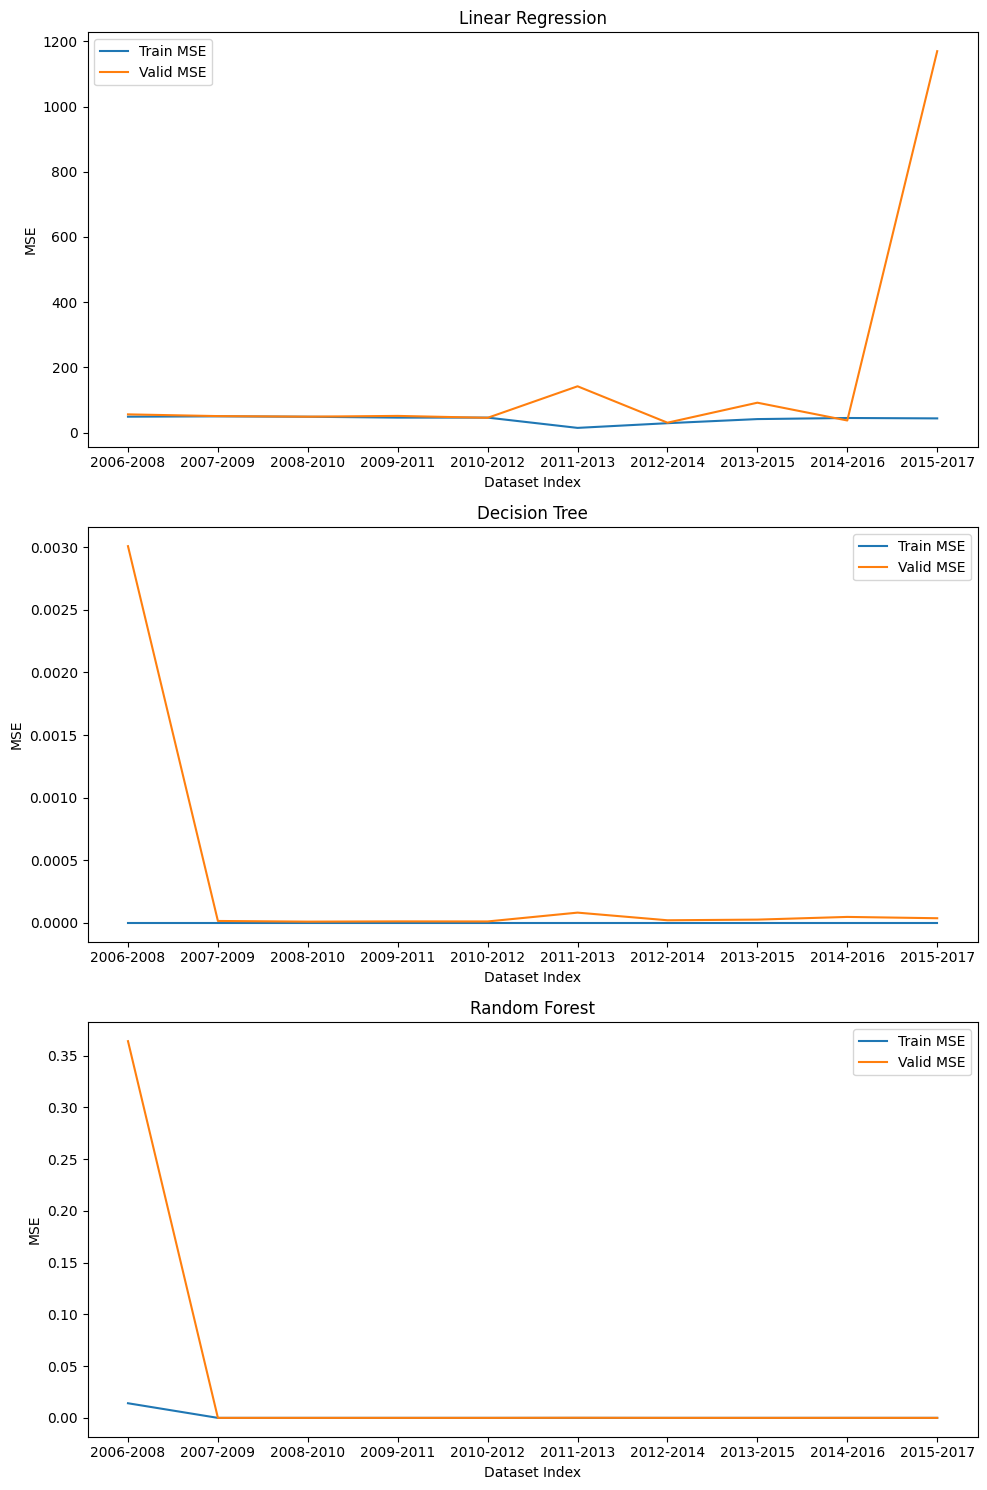

In [36]:
# Define the models to test
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor()
}

# Evaluate all models
model_performance = evaluate_models(X_trains, y_trains, X_valids, y_valids, models)

### Tuned linear regression model

In [37]:
def evaluate_polynomial_models(X_trains, y_trains, X_valids, y_valids, max_degree):
    results = {}
    train_mses = []
    valid_mses = []
    degrees = range(1, max_degree + 1)

    # Ensure that we have the same order of keys for both training and validation sets
    train_keys = list(X_trains.keys())
    valid_keys = list(X_valids.keys())

    # Setup the plot for each degree
    fig, ax = plt.subplots(max_degree+1, figsize=(10, 5 * max_degree))

    for i, degree in enumerate(degrees):
        current_train_mses = []
        current_valid_mses = []

        for j, key in enumerate(train_keys):
            corresponding_valid_key = valid_keys[j]

            # Polynomial feature transformation
            poly = PolynomialFeatures(degree)

            # With Interaction Terms
            # X_train_poly = poly.fit_transform(X_trains[key].select_dtypes(include=['number']))
            # X_valid_poly = poly.transform(X_valids[corresponding_valid_key].select_dtypes(include=['number']))

            # Without Interaction terms
            X_train_poly_full = poly.fit_transform(X_trains[key].select_dtypes(include=['number']))
            X_valid_poly_full = poly.transform(X_valids[corresponding_valid_key].select_dtypes(include=['number']))

            # Identify non-interaction features
            features = poly.get_feature_names_out()
            non_interaction_features = [f for f in features if sum(int(d) for d in f.split() if d.isdigit()) in [0, degree]]

            # Filter out interaction terms
            X_train_poly = X_train_poly_full[:, [features.tolist().index(f) for f in non_interaction_features]]
            X_valid_poly = X_valid_poly_full[:, [features.tolist().index(f) for f in non_interaction_features]]

            # Model training and prediction
            model = LinearRegression()
            model.fit(X_train_poly, y_trains[key])
            y_train_pred = model.predict(X_train_poly)
            y_valid_pred = model.predict(X_valid_poly)

            # Compute MSE
            train_mse = mean_squared_error(y_trains[key], y_train_pred)
            valid_mse = mean_squared_error(y_valids[corresponding_valid_key], y_valid_pred)
            current_train_mses.append(train_mse)
            current_valid_mses.append(valid_mse)

        avg_train_mse = np.mean(current_train_mses)
        avg_valid_mse = np.mean(current_valid_mses)
        train_mses.append(avg_train_mse)
        valid_mses.append(avg_valid_mse)

        results[degree] = {'train_mse': avg_train_mse, 'valid_mse': avg_valid_mse}

        # Plotting for each degree
        ax[i].plot(train_keys, current_train_mses, label='Train MSE')
        ax[i].plot(train_keys, current_valid_mses, label='Valid MSE')
        ax[i].set_title(f'Polynomial Degree {degree}')
        ax[i].set_xlabel('Dataset Index')
        ax[i].set_ylabel('MSE')
        ax[i].legend()

    ax[max_degree].plot(degrees, train_mses, label='Average Train MSE')
    ax[max_degree].plot(degrees, valid_mses, label='Average Valid MSE')
    ax[max_degree].set_xlabel('Polynomial Degree')
    ax[max_degree].set_ylabel('MSE')
    ax[max_degree].set_title('Polynomial Degree vs MSE')
    ax[max_degree].legend()

    plt.tight_layout()
    plt.show()

    best_degree = np.argmin(valid_mses) + 1

    return results, best_degree

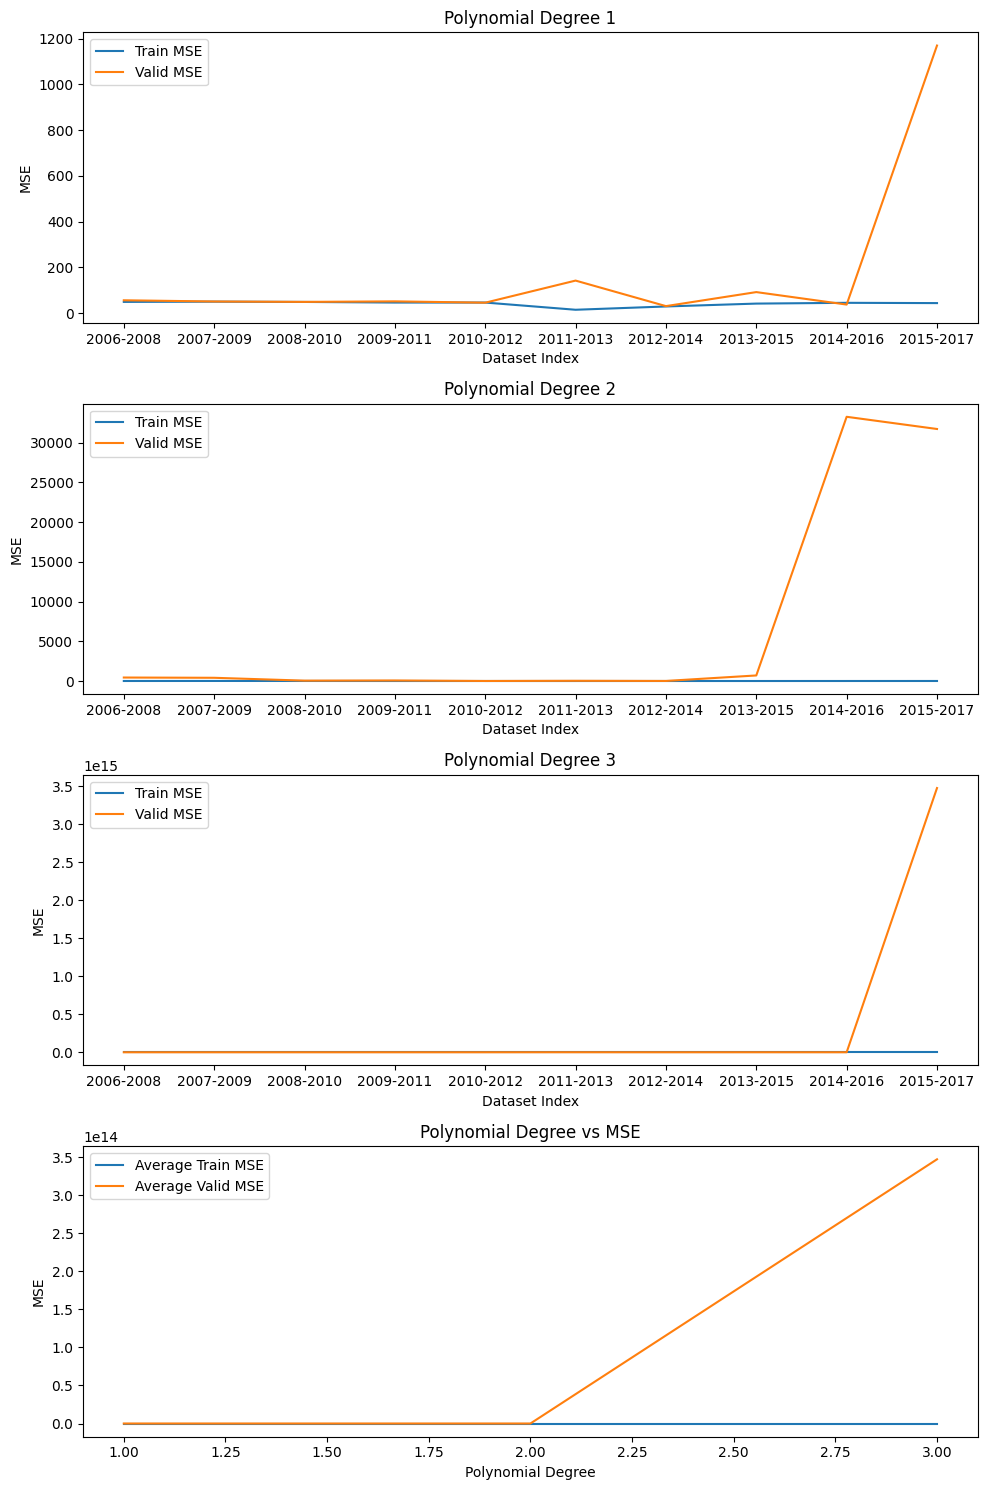

{1: {'train_mse': 41.42510088982863, 'valid_mse': 172.46422347722552}, 2: {'train_mse': 2.118815945428852, 'valid_mse': 6668.064140308788}, 3: {'train_mse': 0.00011831036083182114, 'valid_mse': 347495915703044.4}}
1


In [38]:
# Set the maximum degree of polynomial features you want to test
max_degree = 3

# Call the function with your data
results, best_degree = evaluate_polynomial_models(X_trains, y_trains, X_valids, y_valids, max_degree)
print(results)
print(best_degree)

In [40]:
# Visualize coefficents for the best model for '2006-2008'

# Fit the model
model = LinearRegression().fit(numerical_columns, y_trains[key])

# Coefficients
coefficients = model.coef_

# Feature names
feature_names = numerical_columns.columns

# Combine coefficients and feature names, and sort by the magnitude of coefficients
coeff_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coeff_df = coeff_df.reindex(coeff_df.Coefficient.abs().sort_values(ascending=False).index)

# Plot
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
plt.barh(coeff_df['Feature'], coeff_df['Coefficient'])  # Horizontal bar plot
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.title(f'Feature Importance in Linear Regression Model: {key}')
plt.tight_layout()  # Adjust layout for better fit
plt.show()

ValueError: Expected 2D array, got 1D array instead:
array=['year' 'enrollment' 'responses' 'number_of_comments'
 'Course_Overall_Rating' 'Course_Materials_Rating'
 'Course_Assignments_Rating' 'Course_Feedback_Rating'
 'Course_Section_Rating' 'Course_Workload_Rating'
 'Course_Recommend_Rating' 'Instructor_Return_Rating'
 'Instructor_Feedback_Rating' 'Instructor_Participation_Rating'
 'Instructor_Enthusiasm_Rating' 'Instructor_Accessible_Rating'
 'Instructor_Lectures_Rating' 'Instructor_Overall_Rating'
 'Course_Overall_Respondents' 'Course_Materials_Respondents'
 'Course_Assignments_Respondents' 'Course_Feedback_Respondents'
 'Course_Section_Respondents' 'Course_Workload_Respondents'
 'Course_Recommend_Respondents' 'Instructor_Return_Respondents'
 'Instructor_Feedback_Respondents' 'Instructor_Participation_Respondents'
 'Instructor_Enthusiasm_Respondents' 'Instructor_Accessible_Respondents'
 'Instructor_Lectures_Respondents' 'Instructor_Overall_Respondents'
 'response_rate' 'log_enrollment' 'norm_Course_Workload_Rating'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

### Tuned Decission tree model

In [ ]:
def optimize_decision_tree(X_trains, y_trains, X_valids, y_valids, max_depth_range):
    best_mse = float('inf')
    best_params = None
    results = []
    mses = []
    train_mses = []

    train_keys = list(X_trains.keys())
    valid_keys = list(X_valids.keys())

    for depth in max_depth_range:
        current_mses = []
        current_train_mses = []

        for j, key in enumerate(train_keys):
            corresponding_valid_key = valid_keys[j]

            # Model training and prediction
            model = DecisionTreeRegressor(max_depth=depth)
            model.fit(X_trains[key].select_dtypes(include=['number']), y_trains[key])
            y_train_pred = model.predict(X_trains[key].select_dtypes(include=['number']))
            y_valid_pred = model.predict(X_valids[corresponding_valid_key].select_dtypes(include=['number']))

            # Compute MSE
            train_mse = mean_squared_error(y_trains[key], y_train_pred)
            mse = mean_squared_error(y_valids[corresponding_valid_key], y_valid_pred)
            current_train_mses.append(train_mse)
            current_mses.append(mse)
            
        avg_train_mse = np.mean(current_train_mses)
        avg_mse = np.mean(current_mses)

        mses.append(avg_mse)
        train_mses.append(avg_train_mse)

        if avg_mse < best_mse:
            best_mse = avg_mse
            best_params = depth

    # Plotting the MSEs
    plt.figure(figsize=(10, 6))
    plt.plot(max_depth_range, train_mses, marker='o', label='Train MSE')
    plt.plot(max_depth_range, mses, marker='o', label='Validation MSE')
    plt.xlabel('Max Depth')
    plt.ylabel('Average Validation MSE')
    plt.title('Decision Tree - Max Depth vs. Validation MSE')
    plt.grid(True)
    plt.legend()
    plt.show()

    print(f"Best max_depth: {best_params} with Validation MSE: {best_mse}")
    return results, best_params

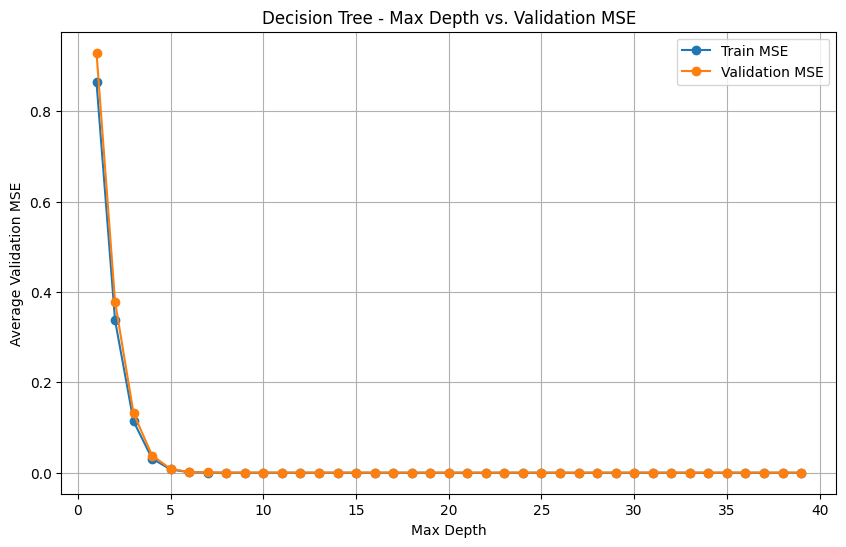

Best max_depth: 27 with Validation MSE: 6.658232966721156e-05


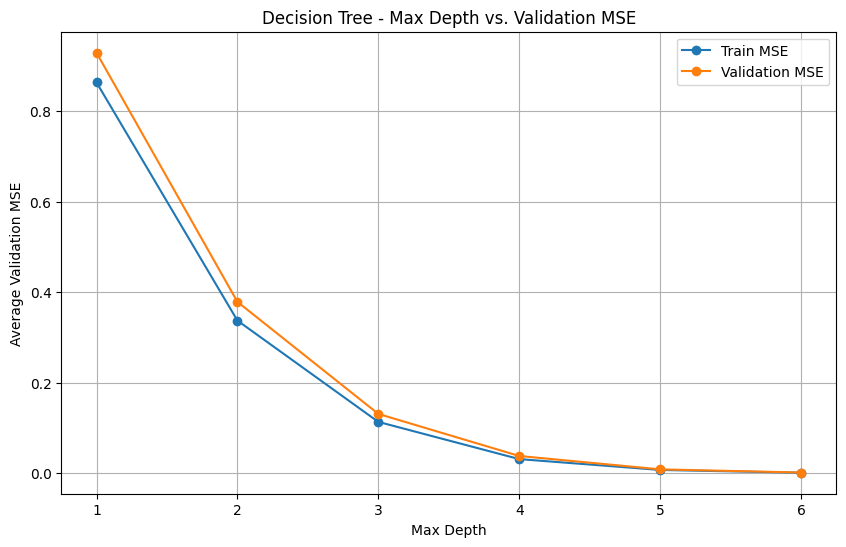

Best max_depth: 6 with Validation MSE: 0.001529559788575978


In [ ]:
max_depth_range = range(1, 40) 
dt_results, dt_best_params = optimize_decision_tree(X_trains, y_trains, X_valids, y_valids, max_depth_range)

# Zoom in 
max_depth_range = range(1, 7) 
dt_results, dt_best_params = optimize_decision_tree(X_trains, y_trains, X_valids, y_valids, max_depth_range)

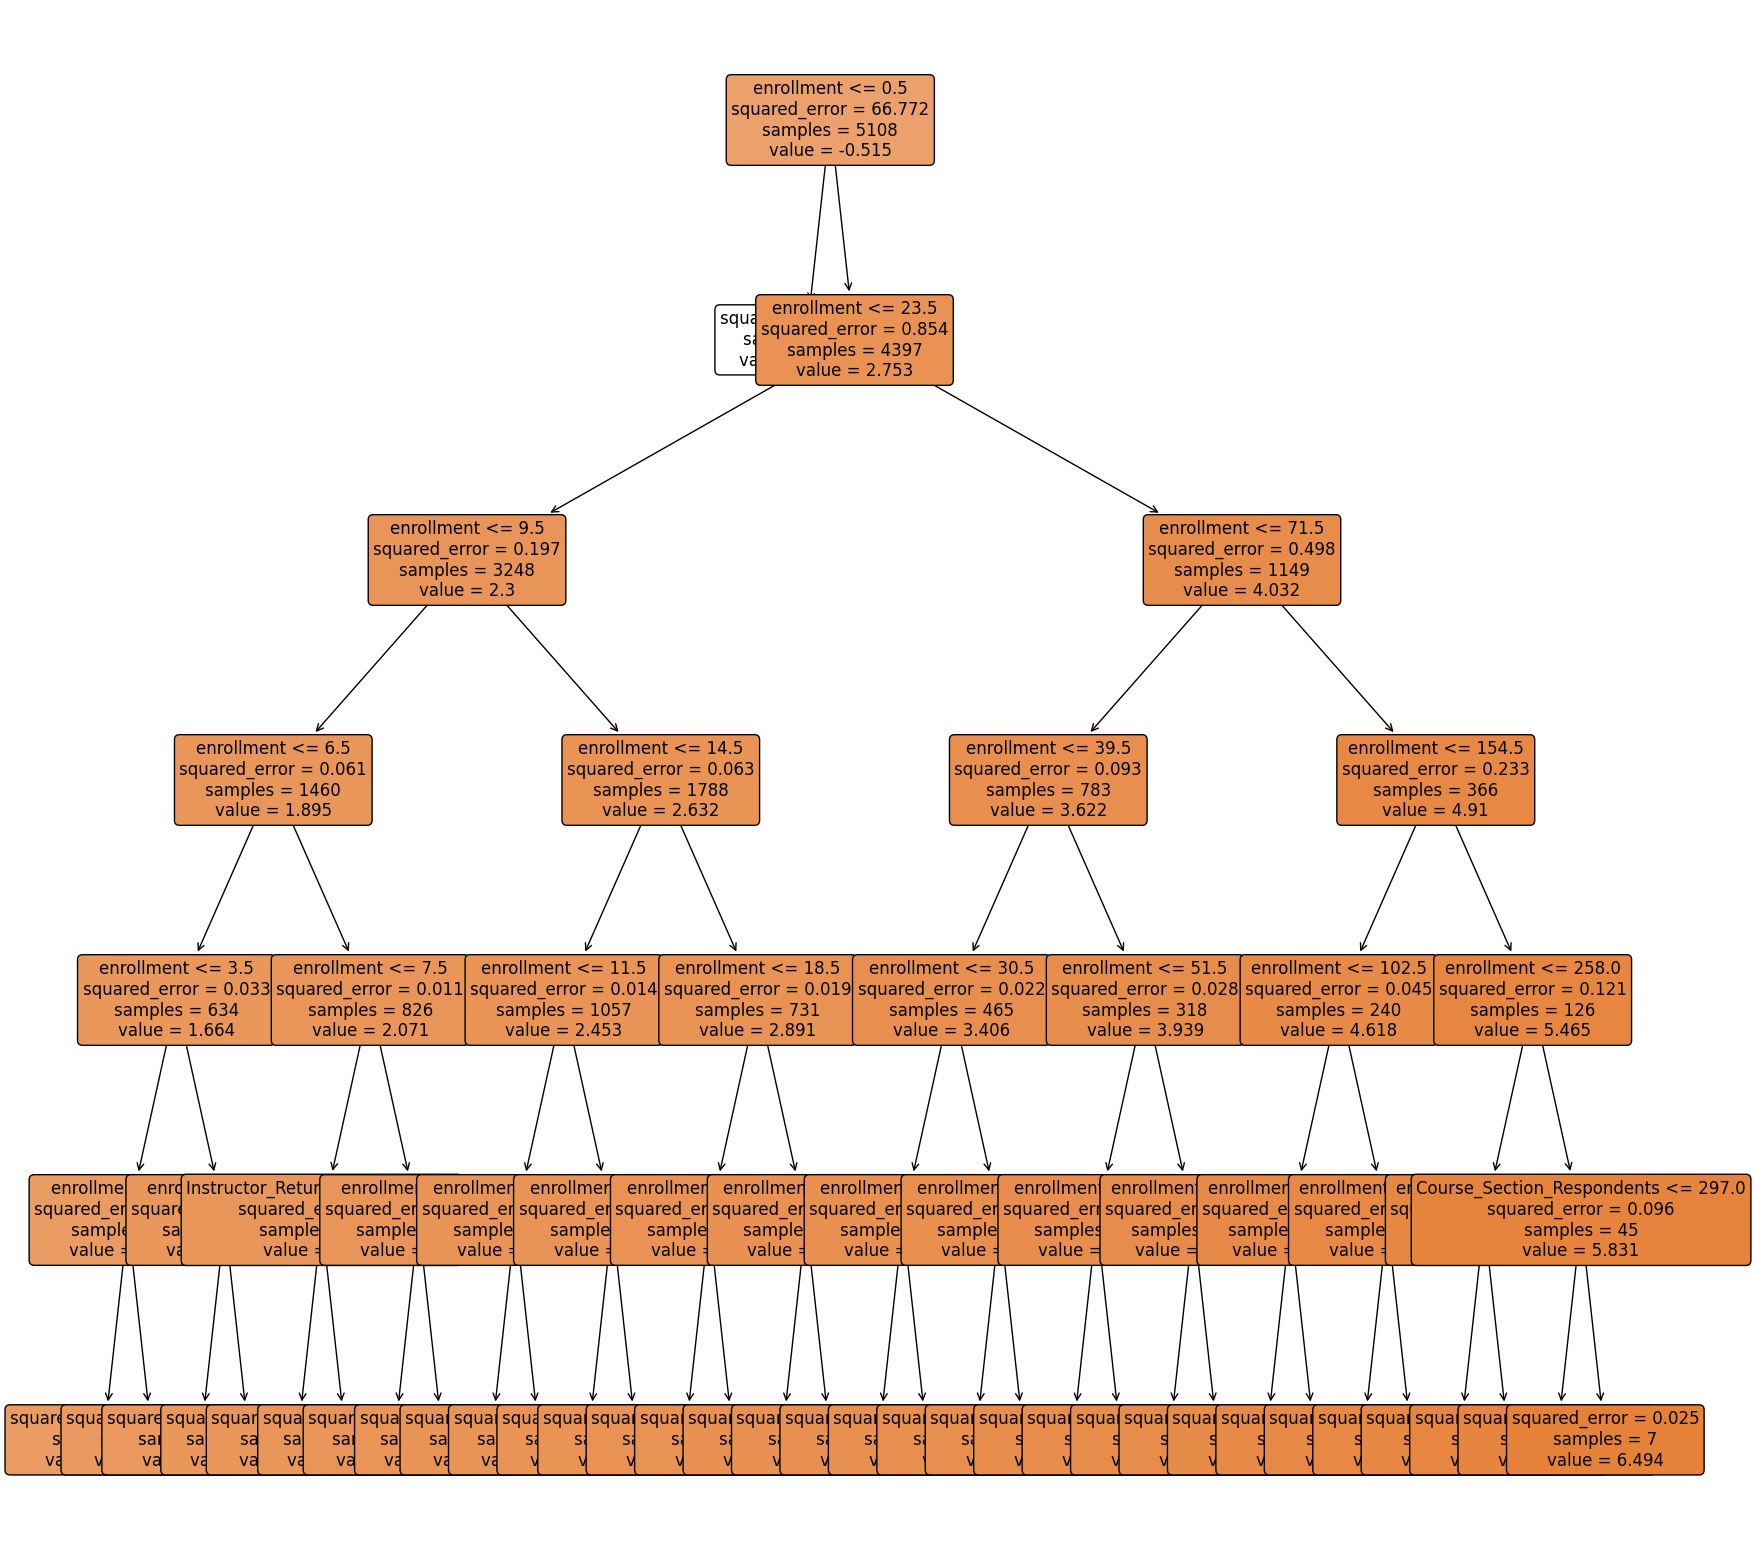

In [ ]:
# Visualize the tree for the best model for '2006-2008'
dt_best = DecisionTreeRegressor(max_depth=dt_best_params)
dt_best.fit(numerical_columns, y_trains[key])

# Visualize the tree
plt.figure(figsize=(20,20))
plot_tree(dt_best, filled=True, feature_names=numerical_columns.columns, rounded=True, fontsize=12)
plt.show()

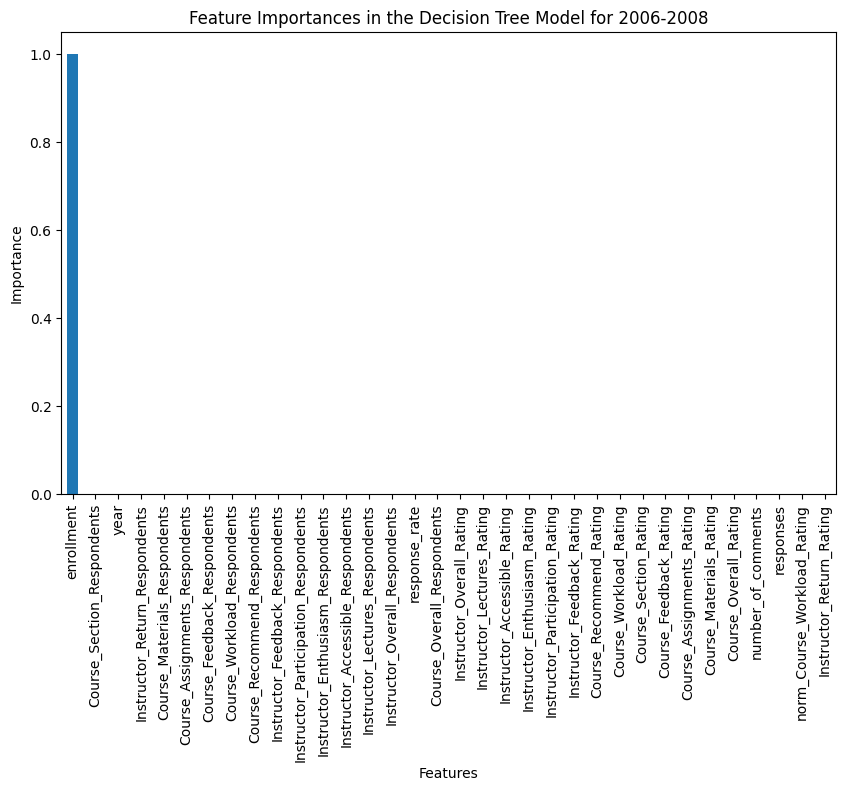

In [ ]:
# Visualize feature importance for the best model per above for '2006-2008'
feature_names = numerical_columns.columns

# Get feature importances and convert them into a Series
importances = pd.Series(dt_best.feature_importances_, index=feature_names)

# Sort the feature importances in descending order
sorted_importances = importances.sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sorted_importances.plot(kind='bar')
plt.title(f"Feature Importances in the Decision Tree Model for {key}")
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

### Method for MSEs

In [ ]:
def get_mses(model, X_trains, y_trains, X_valids, y_valids, X_tests, y_tests):
    # Initialize lists to store MSE values for all datasets
    all_train_mses = []
    all_valid_mses = []
    all_test_mses = []

    train_keys = list(X_trains.keys())
    valid_keys = list(X_valids.keys())

    for j, key in enumerate(train_keys):
        # Validation key and test key are the same
        corresponding_valid_key = valid_keys[j]

        # Train the decision tree on the training data
        model.fit(X_trains[key].select_dtypes(include=['number']), y_trains[key])

        # Predictions on the training, validation, and test datasets
        y_train_pred = model.predict(X_trains[key].select_dtypes(include=['number']))
        y_valid_pred = model.predict(X_valids[corresponding_valid_key].select_dtypes(include=['number']))
        y_test_pred = model.predict(X_tests[corresponding_valid_key].select_dtypes(include=['number']))

        # Calculate the MSE on the training, validation, and test datasets
        train_mse = mean_squared_error(y_trains[key], y_train_pred)
        valid_mse = mean_squared_error(y_valids[corresponding_valid_key], y_valid_pred)
        test_mse = mean_squared_error(y_tests[corresponding_valid_key], y_test_pred)

        # Append the MSE values to the lists
        all_train_mses.append(train_mse)
        all_valid_mses.append(valid_mse)
        all_test_mses.append(test_mse)

    # Calculate the averages of MSE values for all datasets
    best_train_mse = sum(all_train_mses) / len(all_train_mses)
    best_valid_mse = sum(all_valid_mses) / len(all_valid_mses)
    best_test_mse = sum(all_test_mses) / len(all_test_mses)

    # Print the averages
    print(f"Average Train MSE: {best_train_mse}")
    print(f"Average Validation MSE: {best_valid_mse}")
    print(f"Average Test MSE: {best_test_mse}")

    return best_train_mse, best_valid_mse, best_test_mse
    

In [ ]:
dt_best_train_mse, dt_best_valid_mse, dt_best_test_mse = get_mses(dt_best, X_trains, y_trains, X_valids, y_valids, X_tests, y_tests)

Average Train MSE: 0.001087065895580701
Average Validation MSE: 0.001528210291070828
Average Test MSE: 0.0014308848985631983


### Tuned Random forest model

In [ ]:
def optimize_random_forest(X_trains, y_trains, X_valids, y_valids, n_estimators_range, max_depth_range):
    best_mse = float('inf')
    best_params = None
    mse_matrix = np.zeros((len(n_estimators_range), len(max_depth_range)))

    train_keys = list(X_trains.keys())
    valid_keys = list(X_valids.keys())

    for i, n_estimators in enumerate(n_estimators_range):
        for j, max_depth in enumerate(max_depth_range):
            current_mses = []

            for key in train_keys:
                corresponding_valid_key = valid_keys[train_keys.index(key)]

                # Model training and prediction
                model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
                model.fit(X_trains[key].select_dtypes(include=['number']), y_trains[key])
                y_valid_pred = model.predict(X_valids[corresponding_valid_key].select_dtypes(include=['number']))

                # Compute MSE
                mse = mean_squared_error(y_valids[corresponding_valid_key], y_valid_pred)
                current_mses.append(mse)

            avg_mse = np.mean(current_mses)
            mse_matrix[i, j] = avg_mse

            if avg_mse < best_mse:
                best_mse = avg_mse
                best_params = (n_estimators, max_depth)

    # Heatmap plotting
    plt.figure(figsize=(12, 8))
    ax = sns.heatmap(mse_matrix, annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=max_depth_range, yticklabels=n_estimators_range)
    ax.set_xlabel('Max Depth')
    ax.set_ylabel('Number of Estimators')
    ax.set_title('Random Forest MSE Heatmap')
    plt.show()

    print(f"Best parameters: n_estimators={best_params[0]}, max_depth={best_params[1]} with Validation MSE: {best_mse}")
    return best_params, mse_matrix

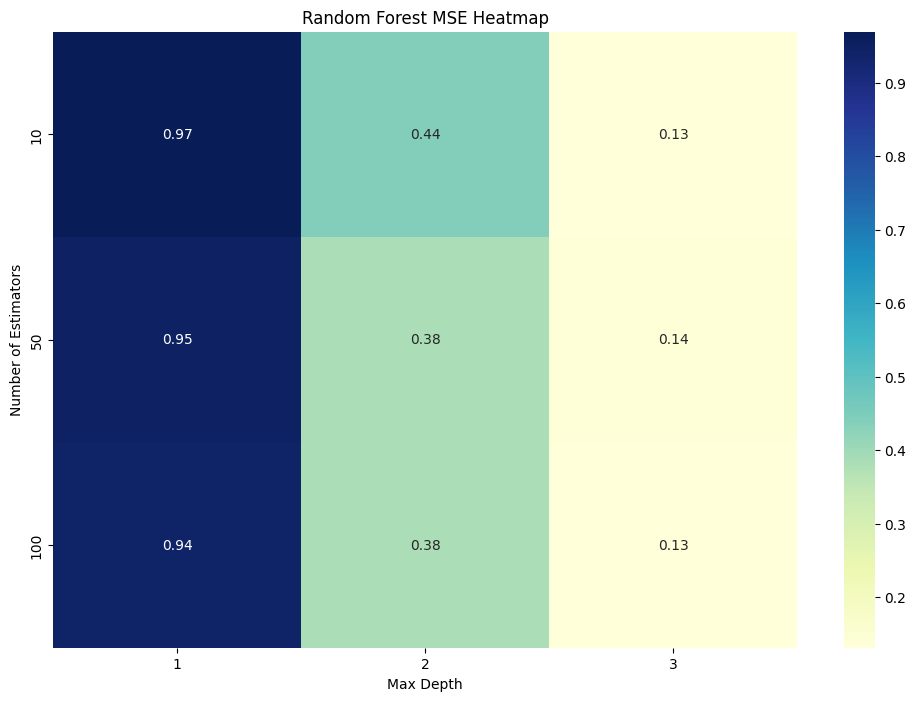

Best parameters: n_estimators=10, max_depth=3 with Validation MSE: 0.13129125770369152


In [ ]:
n_estimators_range = [10, 50, 100, 150, 200]
max_depth_range = range(1, 7)
best_params, mse_matrix = optimize_random_forest(X_trains, y_trains, X_valids, y_valids, n_estimators_range, max_depth_range)

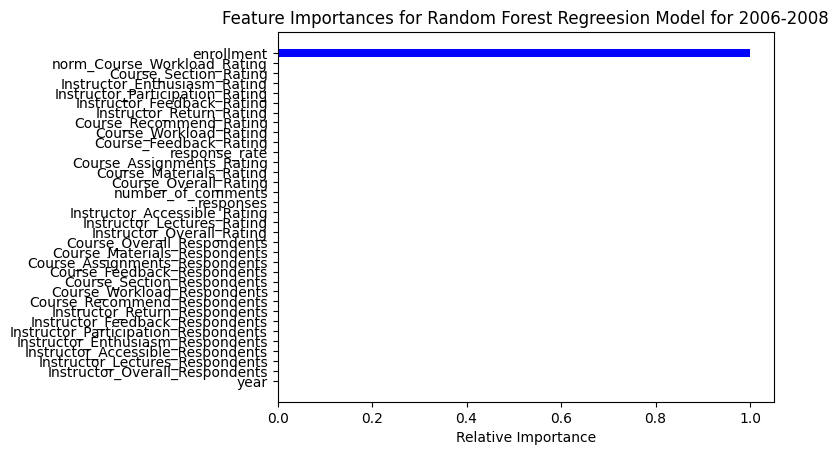

In [ ]:
best_rf = RandomForestRegressor(n_estimators=best_params[0], max_depth=best_params[1])

# Visualize feature importance for the best model per above for '2006-2008'
key = '2006-2008'
best_rf.fit(numerical_columns, y_trains[key])

feature_importances = best_rf.feature_importances_
indices = np.argsort(feature_importances)

# Assuming you have a list of feature names
features = [feature_names[i] for i in indices]

plt.title(f'Feature Importances for Random Forest Regreesion Model for {key}')
plt.barh(range(len(indices)), feature_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features)
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
rf_best_train_mse, rf_best_valid_mse, rf_best_test_mse = get_mses(best_rf, X_trains, y_trains, X_valids, y_valids, X_tests, y_tests)

Average Train MSE: 0.1051619337776872
Average Validation MSE: 0.22378135800154805
Average Test MSE: 0.18606851563901744


# Step 10 PCA:

We wanted to try PCA since it would be useful to look at which components explain the most variance, and since PCA required transformations and wouldn't work as nicely with the baseline models we've done it seperately here:

Fine tune n_components

Best number of PCA components: 2


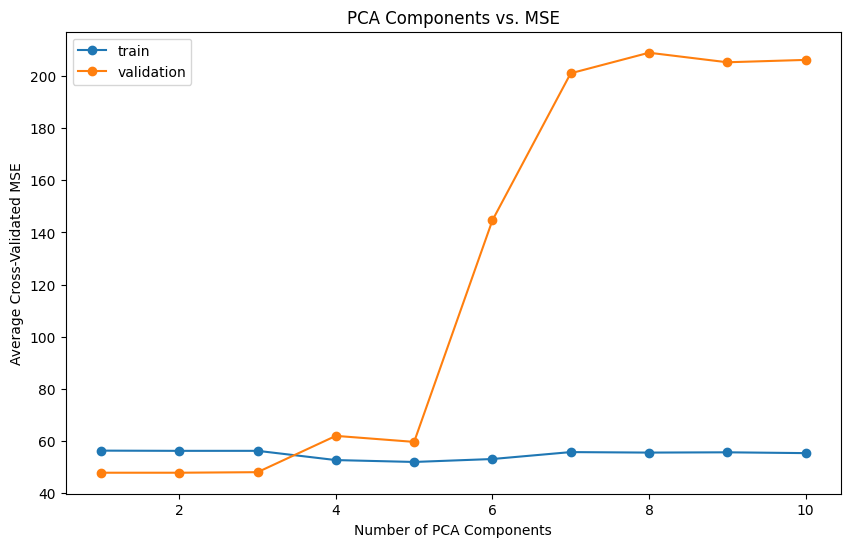

In [ ]:
# Range of PCA components to try
n_components_range = range(1, 11)  # You can adjust the range as needed

# Dictionary to store the average MSE for each number of components
avg_mse_by_component = {}
avg_val_mse_by_component = {}

# Loop over possible numbers of components
for n_components in n_components_range:
    total_mse = 0
    total_val_mse = 0

    for key in X_trains:
        # Find the index of the current key in train_keys
        i = list(X_trains.keys()).index(key)
        
        # Use the index to find the corresponding key in valid_keys
        corresponding_valid_key = list(X_valids.keys())[i]

        # Create a pipeline with PCA and Linear Regression
        pca_model = make_pipeline(PCA(n_components=n_components), LinearRegression())

        # Perform cross-validation and calculate MSE
        mse_scores = -cross_val_score(pca_model, X_trains[key].select_dtypes(include=['number']), y_trains[key], scoring='neg_mean_squared_error')
        total_mse += mse_scores.mean()

        val_mse_scores = -cross_val_score(pca_model, X_valids[corresponding_valid_key].select_dtypes(include=['number']), y_valids[corresponding_valid_key], scoring='neg_mean_squared_error')
        total_val_mse += val_mse_scores.mean()

    # Calculate the average MSE for this number of components
    avg_mse_by_component[n_components] = total_mse / len(X_trains)
    avg_val_mse_by_component[n_components] = total_val_mse / len(X_valids)

# Find the number of components with the lowest average MSE
best_n_components = min(avg_val_mse_by_component, key=avg_val_mse_by_component.get)

print(f"Best number of PCA components: {best_n_components}")

# Plotting the MSEs
plt.figure(figsize=(10, 6))
plt.plot(list(avg_mse_by_component.keys()), list(avg_mse_by_component.values()), marker='o', label = 'train')
plt.plot(list(avg_val_mse_by_component.keys()), list(avg_val_mse_by_component.values()), marker='o', label = 'validation')
plt.xlabel('Number of PCA Components')
plt.ylabel('Average Cross-Validated MSE')
plt.title('PCA Components vs. MSE')
plt.legend()
plt.show()

Run the best PCA model

In [ ]:
avg_train_mse_pca, avg_valid_mse_pca, avg_test_mse_pca = get_mses(make_pipeline(PCA(n_components=best_n_components), LinearRegression()), X_trains, y_trains, X_valids, y_valids, X_tests, y_tests)

Average Train MSE: 55.96717755150763
Average Validation MSE: 48.625262897786065
Average Test MSE: 49.06093163889063


### Cumulative Explained Variance and loading plots

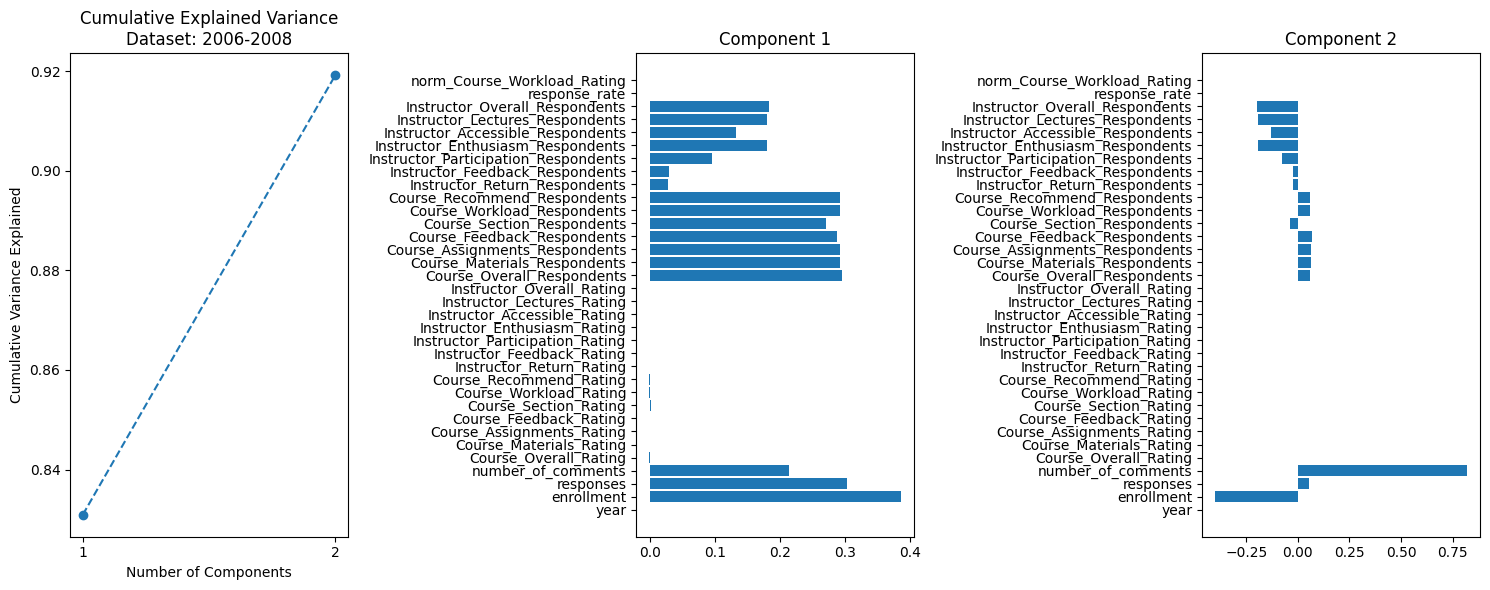

In [ ]:
# Visualize the PCA components for the best model per above for '2006-2008'

dataset_key = '2006-2008'

X_train = X_trains[dataset_key].select_dtypes(include=['number'])

# Fit PCA
pca = PCA(n_components=best_n_components)
pca.fit(X_train)

# Set up the figure for combined plots
plt.figure(figsize=(15, 6))

# Plot for Cumulative Explained Variance
plt.subplot(1, best_n_components + 1, 1)  # Adding 1 for the cumulative plot
plt.plot(range(1, best_n_components + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.title(f'Cumulative Explained Variance\nDataset: {dataset_key}')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.xticks(range(1, best_n_components + 1))

# Component Loadings Plots
for i, component in enumerate(pca.components_):
    plt.subplot(1, best_n_components + 1, i + 2)  # Positioning component plots
    plt.barh(range(len(component)), component, align='center')
    plt.title(f'Component {i + 1}')
    plt.yticks(range(len(X_train.columns)), X_train.columns)

plt.tight_layout()
plt.show()

# Step 11: Trying to fix the linear regression using regularization

We had high hopes for our linear regression Model because of the coefficents on variables, however, it is still not nearly as accurate as our random forest or decision tree model and so we try to regualrize them

Given that the best model is of degree 1, we train this model

In [ ]:
# Initialize arrays to store MSEs and weighted coefficients
total_train_mse = 0
total_valid_mse = 0
weighted_coefficients = np.zeros(len(X_trains[list(X_trains.keys())[0]].select_dtypes(include=['number']).columns))
total_weight = 0

# Train a model for each dataset and calculate MSEs
for key in X_trains:
    # Find the index of the current key in train_keys
    i = list(X_trains.keys()).index(key)
    
    # Use the index to find the corresponding key in valid_keys
    corresponding_valid_key = list(X_valids.keys())[i]

    # Train the model
    model = LinearRegression()
    model.fit(X_trains[key].select_dtypes(include=['number']), y_trains[key])

    # Predict and calculate MSE for training data
    y_train_pred = model.predict(X_trains[key].select_dtypes(include=['number']))
    train_mse = mean_squared_error(y_trains[key], y_train_pred)
    total_train_mse += train_mse

    # Predict and calculate MSE for validation data
    y_valid_pred = model.predict(X_valids[corresponding_valid_key].select_dtypes(include=['number']))
    valid_mse = mean_squared_error(y_valids[corresponding_valid_key], y_valid_pred)
    total_valid_mse += valid_mse

    # Weight coefficients by validation MSE and sum up
    weighted_coefficients += model.coef_ * valid_mse
    total_weight += valid_mse

# Average out the coefficients
avg_coefficients = weighted_coefficients / total_weight

# Calculate average MSEs
avg_train_mse = total_train_mse / len(X_trains)
avg_valid_mse = total_valid_mse / len(X_valids)

features = X_trains[list(X_trains.keys())[0]].select_dtypes(include=['number']).columns

# Print the average MSEs
print(f"\nAverage Train MSE: {avg_train_mse}")
print(f"Average Validation MSE: {avg_valid_mse}")


Average Train MSE: 41.425100889829004
Average Validation MSE: 172.4642234772264


### Feature importance

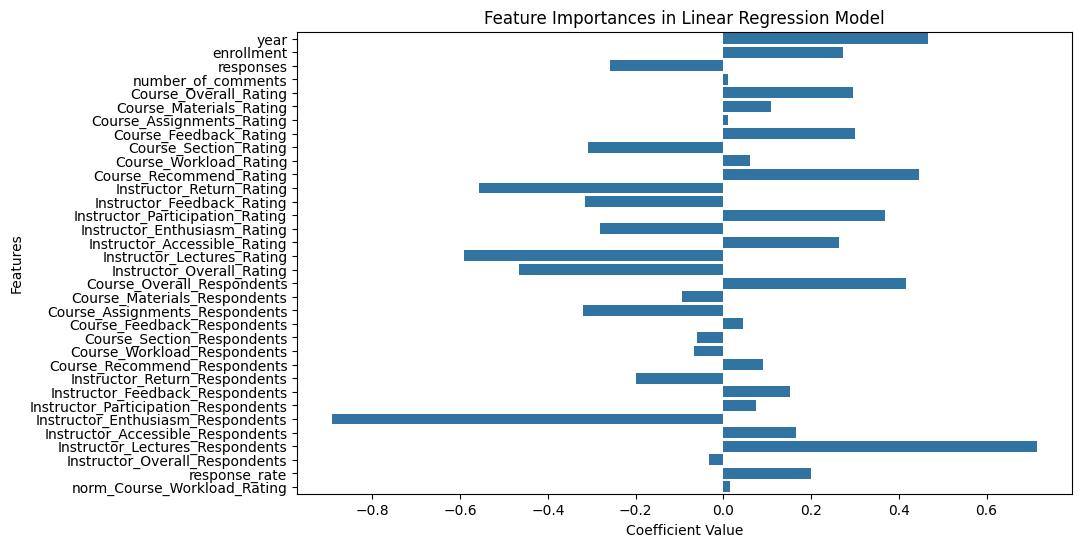

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_coefficients, y=features)
plt.title('Feature Importances in Linear Regression Model')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.show()

### L1 Regularization 

Function to finetune:

In [ ]:
from sklearn.preprocessing import StandardScaler

def tune_regularization_model(X_trains, y_trains, X_valids, y_valids, alpha_range, regularization_type='ridge', max_iter=10000):
    avg_train_mse = {}
    avg_valid_mse = {}

    # Choose the model type based on the input
    Model = Ridge if regularization_type == 'ridge' else Lasso

    # Loop over possible alpha values
    for alpha in alpha_range:
        total_train_mse = 0
        total_valid_mse = 0

        # Train a model for each dataset
        for key in X_trains:
            corresponding_valid_key = list(X_valids.keys())[list(X_trains.keys()).index(key)]

            # Standardize the features
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_trains[key].select_dtypes(include=['number']))
            X_valid_scaled = scaler.transform(X_valids[corresponding_valid_key].select_dtypes(include=['number']))

            # Train the model with increased max_iter
            model = Model(alpha=alpha, max_iter=max_iter)
            model.fit(X_train_scaled, y_trains[key])

            # Compute MSE
            y_train_pred = model.predict(X_train_scaled)
            y_valid_pred = model.predict(X_valid_scaled)
            total_train_mse += mean_squared_error(y_trains[key], y_train_pred)
            total_valid_mse += mean_squared_error(y_valids[corresponding_valid_key], y_valid_pred)

        avg_train_mse[alpha] = total_train_mse / len(X_trains)
        avg_valid_mse[alpha] = total_valid_mse / len(X_valids)

    # Find the best alpha value
    best_alpha = min(avg_valid_mse, key=avg_valid_mse.get)

    # Plotting the MSEs
    plt.figure(figsize=(12, 6))
    plt.plot(list(avg_train_mse.keys()), list(avg_train_mse.values()), marker='o', label=f'{regularization_type.capitalize()} Train MSE')
    plt.plot(list(avg_valid_mse.keys()), list(avg_valid_mse.values()), marker='o', label=f'{regularization_type.capitalize()} Validation MSE')
    plt.xscale('log')
    plt.xlabel('Alpha')
    plt.ylabel('Average MSE')
    plt.title(f'{regularization_type.capitalize()} Regression Alpha vs. MSE')
    plt.legend()
    plt.show()

    return best_alpha, avg_train_mse, avg_valid_mse

Finetune Alpha

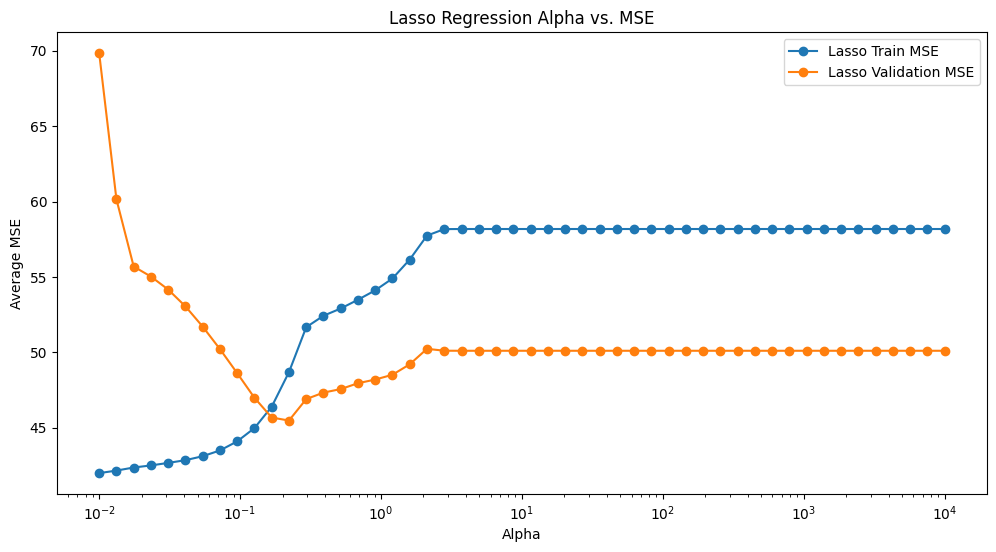

Best alpha for Lasso: 0.22229964825261944


In [ ]:
alpha_range = np.logspace(-2, 4, 50)
best_alpha_lasso, train_mse_lasso, valid_mse_lasso = tune_regularization_model(X_trains, y_trains, X_valids, y_valids, alpha_range, 'lasso')
print("Best alpha for Lasso:", best_alpha_lasso)

Train best model:

In [ ]:
avg_train_mse_lasso, avg_valid_mse_lasso, avg_test_mse_lasso = get_mses(Lasso(alpha=best_alpha_lasso, max_iter=10000), X_trains, y_trains, X_valids, y_valids, X_tests, y_tests)

c:\Users\AndrewsMatthewHaines\OneDrive - Harvard University\Documents\GitHub\cs109a_final_project\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.696e+02, tolerance: 4.191e+01
  model = cd_fast.enet_coordinate_descent(


Average Train MSE: 43.24314582530458
Average Validation MSE: 87.04173703008674
Average Test MSE: 88.07614331229472


### L2 Regularization 

Finetune Alpha

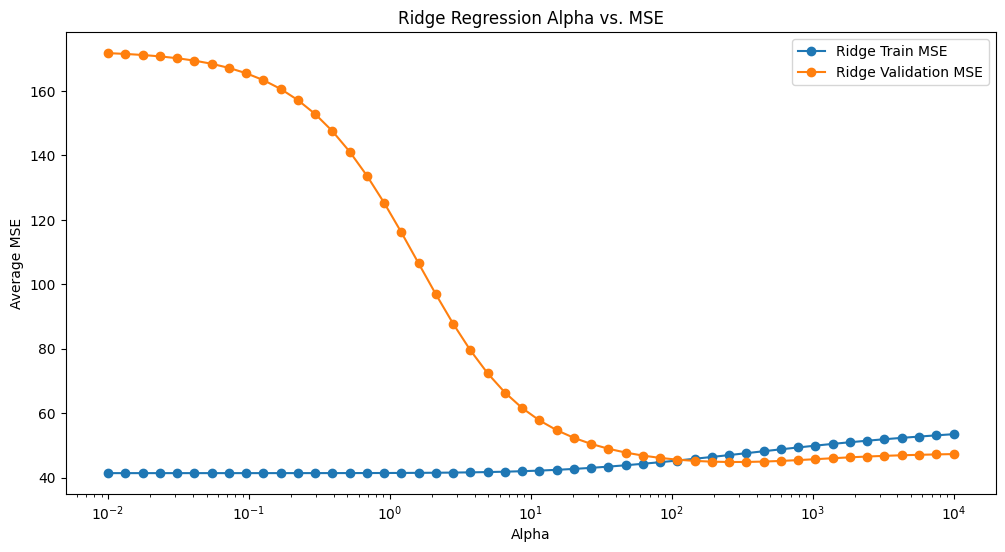

Best alpha for Ridge: 255.95479226995332


In [ ]:
best_alpha_ridge, train_mse_ridge, valid_mse_ridge = tune_regularization_model(X_trains, y_trains, X_valids, y_valids, alpha_range, 'ridge')
print("Best alpha for Ridge:", best_alpha_ridge)

Train best model

In [ ]:
avg_train_mse_ridge, avg_valid_mse_ridge, avg_test_mse_ridge = get_mses(Ridge(alpha=best_alpha_ridge, max_iter=10000), X_trains, y_trains, X_valids, y_valids, X_tests, y_tests)

Average Train MSE: 42.089552806901715
Average Validation MSE: 153.22904694123892
Average Test MSE: 136.15751965649633


# Step 12: Aggregate into results table

In [ ]:
accuracy_values = {
    f"Best decision tree: max_depth = {dt_best_params}": {"train": dt_best_train_mse, "val": dt_best_valid_mse ,"test": dt_best_test_mse},
    f"Best Random Forest: n_estimators = {best_params[0]} max_depth = {best_params[1]}": {"train": rf_best_train_mse, "val": rf_best_valid_mse,"test": rf_best_test_mse},
    f"Best PCA, n_components = {best_n_components}": {"train": avg_train_mse_pca, "val": avg_valid_mse_pca, "test": avg_test_mse_pca},
    f"Best Ridge, alpha = {round(best_alpha_ridge,2)}": {"train": avg_train_mse_ridge, "val": avg_valid_mse_ridge, "test": avg_test_mse_ridge},
    f"Best Lasso, alpha = {round(best_alpha_lasso,2)}": {"train": avg_train_mse_lasso, "val": avg_valid_mse_lasso, "test": avg_test_mse_lasso}
}

# Creating the DataFrame
results_df = pd.DataFrame(accuracy_values).transpose()
results_df.columns = ['training accuracy', 'validation accuracy', 'test accuracy']

In [ ]:
# display results
results_df

,training accuracy,validation accuracy,test accuracy
Best decision tree: max_depth = 6,0.001,0.002,0.001
Best Random Forest: n_estimators = 10 max_depth = 3,0.105,0.224,0.186
"Best PCA, n_components = 2",55.967,48.625,49.061
"Best Ridge, alpha = 255.95",42.090,153.229,136.158
"Best Lasso, alpha = 0.22",43.243,87.042,88.076


# Step 13: Interpretation of results

It's clear that the Best decision tree: max_depth = 27 is the best model followed by Best Random Forest: n_estimators = 100 max_depth = 5.


TODO: FIX

# Step 14: Final Model

In [ ]:
# TODO 

## Look at where the model performs well (Arts, science etc.) - i.e. after testing look at MSE's grouped by X 

## Maybe connect to EDA

## TODO: 

**Can someone do the latest of bagging/ boosting for the decision trees**

**maybe print the trees look at the top branch**

**Big Q:**
- Check weighting over MSE thing? Goal isn't one model is it?
- Maybe method for getting MSEs/ efficency


**Mike** - Add explanations after each step of why try this

**HT** - Do baseline models for Decision tree, random forest

**Matt**
- Check weighting over MSE thing? Goal isn't one model is it?

- Make sure you're predicting using average coefficents?

- Maybe average all models (1/MSE)
- More Feature importance 
- Look at where the model performs well (Arts, science etc.) - i.e. after testing look at MSE's grouped by X 

**Dan:**
- Maybe connect EDA to end 
- Check boxes for Milestones 